In [2]:
from snowflake.snowpark import functions as F
from snowflake.snowpark.window import Window
import pandas as pd
import re
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime

In [3]:
import json
from snowflake.snowpark import Session

# Load connection parameters
with open('config.json') as f:
    connection_parameters = json.load(f)

# Create Snowpark session
session = Session.builder.configs(connection_parameters).create()

try:
    session.sql("SELECT CURRENT_WAREHOUSE(), CURRENT_DATABASE(), CURRENT_SCHEMA()").show()
    print("Successfully connected to Snowflake!") 
except Exception as e:
    print(f"Error connecting to Snowflake: {str(e)}") 
    raise

---------------------------------------------------------------------
|"CURRENT_WAREHOUSE()"  |"CURRENT_DATABASE()"  |"CURRENT_SCHEMA()"  |
---------------------------------------------------------------------
|COMPUTE_WH             |GTFS_TEST             |NULL                |
---------------------------------------------------------------------

Successfully connected to Snowflake!


In [4]:
query = """
WITH ranked AS (
    SELECT
        t.*,
        ROW_NUMBER() OVER (
            PARTITION BY TO_DATE(t.SCHEDULE_TIMESTAMP)
            ORDER BY RANDOM()
        ) AS rn
    FROM DATASETS.DELAYS_DATASETS t
),
sampled AS (
    SELECT *
    FROM ranked
    WHERE rn <= 6000 
),
joined AS (
    SELECT 
        s.TRIP_ID,
        s.STOP_ID,
        s.STOP_NAME,
        s.TRIP_HEADSIGN,
        s.STOP_SEQUENCE,
        s.ACTUAL_ARRIVAL,
        s.ROUTE_SHORT_NAME,
        s.PLANNED_ARRIVAL,
        s.MODE,
        s.EVENT_DATE,
        s.LOAD_TIMESTAMP,
        s.SCHEDULE_TIMESTAMP,
        s.DELAY,
        o.STOP_LAT,
        o.STOP_LON,
        st.SHAPE_DIST_TRAVELED,
        ROW_NUMBER() OVER(
            PARTITION BY s.TRIP_ID, s.STOP_ID, s.STOP_NAME, s.TRIP_HEADSIGN, s.PLANNED_ARRIVAL 
            ORDER BY s.LOAD_TIMESTAMP DESC
        ) as rn_j
    FROM sampled s
    LEFT JOIN SCHEDULE.STOPS o
        ON s.STOP_ID = o.STOP_ID
        AND s.MODE = o.MODE
        AND s.STOP_NAME = o.STOP_NAME
    LEFT JOIN SCHEDULE.STOP_TIMES st
        ON s.STOP_ID = st.STOP_ID
        AND s.TRIP_ID = st.TRIP_ID
        AND s.STOP_SEQUENCE = st.STOP_SEQUENCE
        AND s.MODE = st.MODE
)SELECT
    j.TRIP_ID,
    j.STOP_ID,
    j.STOP_NAME,
    j.TRIP_HEADSIGN,
    j.STOP_SEQUENCE,
    j.ACTUAL_ARRIVAL,
    j.ROUTE_SHORT_NAME,
    j.PLANNED_ARRIVAL,
    j.MODE,
    j.EVENT_DATE,
    j.LOAD_TIMESTAMP,
    j.SCHEDULE_TIMESTAMP,
    j.DELAY,
    j.STOP_LAT,
    j.STOP_LON,
    j.SHAPE_DIST_TRAVELED
FROM joined j
WHERE j.rn_j = 1;
"""


In [5]:
"""df_snow = session.sql(query)

df = df_snow.to_pandas()

current_timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

df.to_csv(f"delays_dataset_sample_{current_timestamp}.csv", index=False)"""

'df_snow = session.sql(query)\n\ndf = df_snow.to_pandas()\n\ncurrent_timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")\n\ndf.to_csv(f"delays_dataset_sample_{current_timestamp}.csv", index=False)'

In [6]:
df = pd.read_csv("delays_dataset_sample_20251121_171631.csv", parse_dates=['ACTUAL_ARRIVAL', 'PLANNED_ARRIVAL', 'EVENT_DATE'])

In [7]:
df

,TRIP_ID,STOP_ID,STOP_NAME,TRIP_HEADSIGN,STOP_SEQUENCE,ACTUAL_ARRIVAL,ROUTE_SHORT_NAME,PLANNED_ARRIVAL,MODE,EVENT_DATE,LOAD_TIMESTAMP,SCHEDULE_TIMESTAMP,DELAY,STOP_LAT,STOP_LON,SHAPE_DIST_TRAVELED
0,1529_45832,195,Kruszwicka,Lesisko,17,2025-10-24 13:57:17,193,2025-10-24 13:54:00,M,2025-10-24,2025-10-24 11:50:00.000000,2025-10-25 00:00:00.000000,3,50.097470,20.019210,NaN
1,block_77_trip_7_service_1,stop_1006_250001,Cracovia Błonia,Cracovia Stadion,12,2025-10-29 06:53:09,134,2025-10-29 06:52:00,A,2025-10-29,2025-10-29 05:45:00.000000,2025-10-29 00:00:00.000000,1,50.058785,19.921688,6.256
2,block_625_trip_5_service_2,stop_2537_358802,Giełda Balicka,Piaski Nowe,9,2025-09-06 07:33:00,164,2025-09-06 07:33:00,A,2025-09-06,2025-09-06 05:25:00.000000,2025-09-07 00:00:00.000000,0,50.081541,19.875853,3.380
3,block_60_trip_6_service_3,stop_1494_373129,Papierni Prądnickich,Nowy Bieżanów P+R,2,2025-09-01 01:37:00,69,2025-09-01 01:37:00,T,2025-09-01,2025-08-31 23:30:00.000000,2025-08-30 00:00:00.000000,0,50.101630,19.957300,0.680
4,block_1072_trip_5_service_3,stop_1864_320901,Brzezie Kluczwody,Bronowice Małe,5,2025-09-07 12:16:23,288,2025-09-07 12:16:00,A,2025-09-07,2025-09-07 10:10:00.000000,2025-09-07 00:00:00.000000,0,50.129237,19.821835,3.050
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
128041,block_286_trip_14_service_1,stop_756_108001,Węgrzce Pętla,Węgrzce Pętla,8,2025-10-29 09:38:21,217,2025-10-29 09:37:00,A,2025-10-29,2025-10-29 08:30:00,2025-10-29 00:00:00.000000,1,50.128736,19.974743,3.620
128042,block_979_trip_7_service_3,stop_641_92301,Beskidzka,Os. Kurdwanów,19,2025-10-19 15:06:42,179,2025-10-19 15:05:00,A,2025-10-19,2025-10-19 13:00:00,2025-10-19 00:00:00.000000,1,50.018674,19.951653,9.585
128043,1529_53363,72,Rondo 308. Dywizjonu,Czerwone Maki P+R,6,2025-10-24 21:47:14,578,2025-10-24 21:46:00,M,2025-10-24,2025-10-24 19:40:00,2025-10-25 00:00:00.000000,1,50.068200,20.004110,NaN
128044,block_96_trip_14_service_1,stop_65_9002,Mazowiecka,Prądnik Biały,20,2025-09-01 20:12:51,144,2025-09-01 20:11:00,A,2025-09-01,2025-09-01 18:05:00,2025-09-01 18:36:13.672163,1,50.078621,19.918174,12.130


In [8]:
query2 = '''
SELECT * FROM WEATHER_API_STAGING.DISTRICT_LOCATIONS
'''

In [9]:
df_snow2 = session.sql(query2)

df_district_locations = df_snow2.to_pandas()


# 1. Znajdź wiersz, gdzie kolumna 'LONGITUDE' JEST RÓWNA minimalnej wartości.
min_longitude_district = df_district_locations.loc[
    df_district_locations['LONGITUDE'] == df_district_locations['LONGITUDE'].min()
]

# 2. To samo dla maksymalnej długości
max_longitude_district = df_district_locations.loc[
    df_district_locations['LONGITUDE'] == df_district_locations['LONGITUDE'].max()
]

# 3. I dla szerokości
min_latitude_district = df_district_locations.loc[
    df_district_locations['LATITUDE'] == df_district_locations['LATITUDE'].min()
]

# 4. Oraz maksymalnej szerokości
max_latitude_district = df_district_locations.loc[
    df_district_locations['LATITUDE'] == df_district_locations['LATITUDE'].max()
]

center_district = df_district_locations.loc[df_district_locations['DISTRICT_NUMBER'] == 1]

df_relevant_districts = pd.concat([min_longitude_district, max_longitude_district, min_latitude_district, max_latitude_district, center_district])


df_relevant_districts.index = df_relevant_districts['DISTRICT_NAME']

json_districts = df_relevant_districts.to_json(orient='records')

In [10]:
def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # promień Ziemi w km
    phi1, phi2 = np.radians(lat1), np.radians(lat2)
    dphi = np.radians(lat2 - lat1)
    dlambda = np.radians(lon2 - lon1)

    a = np.sin(dphi/2)**2 + np.cos(phi1) * np.cos(phi2) * np.sin(dlambda/2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    return R * c


for item in json.loads(json_districts):
    col_name = f"dist_{item['DISTRICT_NAME']}"
    df[col_name] = df.apply(lambda row: haversine(row["STOP_LAT"], row["STOP_LON"], item["LATITUDE"],  item["LONGITUDE"]), axis=1)

In [11]:
df.head()

,TRIP_ID,STOP_ID,STOP_NAME,TRIP_HEADSIGN,STOP_SEQUENCE,ACTUAL_ARRIVAL,ROUTE_SHORT_NAME,PLANNED_ARRIVAL,MODE,EVENT_DATE,...,SCHEDULE_TIMESTAMP,DELAY,STOP_LAT,STOP_LON,SHAPE_DIST_TRAVELED,dist_Prądnik Biały (IV),dist_Nowa Huta (XVIII),dist_Swoszowice (X),dist_Bieńczyce (XVI),dist_Stare Miasto (I)
0,1529_45832,195,Kruszwicka,Lesisko,17,2025-10-24 13:57:17,193,2025-10-24 13:54:00,M,2025-10-24,...,2025-10-25 00:00:00.000000,3,50.097470,20.019210,NaN,9.709155,12.295157,15.035563,4.596268,7.093892
1,block_77_trip_7_service_1,stop_1006_250001,Cracovia Błonia,Cracovia Stadion,12,2025-10-29 06:53:09,134,2025-10-29 06:52:00,A,2025-10-29,...,2025-10-29 00:00:00.000000,1,50.058785,19.921688,6.256,3.967797,19.417898,9.632392,12.656767,1.146057
2,block_625_trip_5_service_2,stop_2537_358802,Giełda Balicka,Piaski Nowe,9,2025-09-06 07:33:00,164,2025-09-06 07:33:00,A,2025-09-06,...,2025-09-07 00:00:00.000000,0,50.081541,19.875853,3.380,0.740551,22.458633,12.877525,14.961215,4.919766
3,block_60_trip_6_service_3,stop_1494_373129,Papierni Prądnickich,Nowy Bieżanów P+R,2,2025-09-01 01:37:00,69,2025-09-01 01:37:00,T,2025-09-01,...,2025-08-30 00:00:00.000000,0,50.101630,19.957300,0.680,5.506114,16.735142,14.395367,8.881175,4.698345
4,block_1072_trip_5_service_3,stop_1864_320901,Brzezie Kluczwody,Bronowice Małe,5,2025-09-07 12:16:23,288,2025-09-07 12:16:00,A,2025-09-07,...,2025-09-07 00:00:00.000000,0,50.129237,19.821835,3.050,6.620281,26.740082,19.266496,18.651049,11.165299


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128046 entries, 0 to 128045
Data columns (total 21 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   TRIP_ID                  128046 non-null  object        
 1   STOP_ID                  128046 non-null  object        
 2   STOP_NAME                128046 non-null  object        
 3   TRIP_HEADSIGN            128046 non-null  object        
 4   STOP_SEQUENCE            128046 non-null  int64         
 5   ACTUAL_ARRIVAL           128046 non-null  datetime64[ns]
 6   ROUTE_SHORT_NAME         128046 non-null  int64         
 7   PLANNED_ARRIVAL          128046 non-null  datetime64[ns]
 8   MODE                     128046 non-null  object        
 9   EVENT_DATE               128046 non-null  datetime64[ns]
 10  LOAD_TIMESTAMP           128046 non-null  object        
 11  SCHEDULE_TIMESTAMP       128046 non-null  object        
 12  DELAY           

In [13]:
num_features = df[['DELAY', 'SHAPE_DIST_TRAVELED', 'dist_Stare Miasto (I)', 'dist_Prądnik Biały (IV)', 'dist_Swoszowice (X)', 'dist_Bieńczyce (XVI)', 'dist_Nowa Huta (XVIII)']]

num_features.describe()

,DELAY,SHAPE_DIST_TRAVELED,dist_Stare Miasto (I),dist_Prądnik Biały (IV),dist_Swoszowice (X),dist_Bieńczyce (XVI),dist_Nowa Huta (XVIII)
count,128046.000000,93768.000000,128046.000000,128046.000000,128046.000000,128046.000000,128046.000000
mean,2.972033,7.363969,5.474209,7.852305,11.174167,11.216381,17.366141
std,11.013915,5.322034,28.672559,28.702175,28.633651,28.837690,28.862224
min,0.000000,0.000000,0.253840,0.317295,0.319916,0.185733,0.657001
25%,0.000000,2.980000,2.759033,4.816758,8.286926,7.883512,14.266315
50%,1.000000,6.610000,4.753749,7.233073,11.199484,11.213791,17.505546
75%,3.000000,10.912000,7.049465,9.876272,13.462805,13.486624,19.643113
max,715.000000,34.136000,5879.947720,5880.740998,5871.059122,5889.074816,5890.147741


### Wnioski 1

* DELAY - 
Dane są bardzo niestabilne, mocno chaotyczne i różnią się między sobą.
Średnia nie opisuje ich dobrze.
średnia = 3
odchylenie standardowe = 11

* ODLEGŁOŚCI - Maksymalne wartości w kolumnach "dist_", fizycznie niemożliwe dla komunikacji miejskiej. Mogą sugerować poważne błędy pomiaru lub błędy w danych źródłowych. Konieczna obłsuga wartości odstających. 

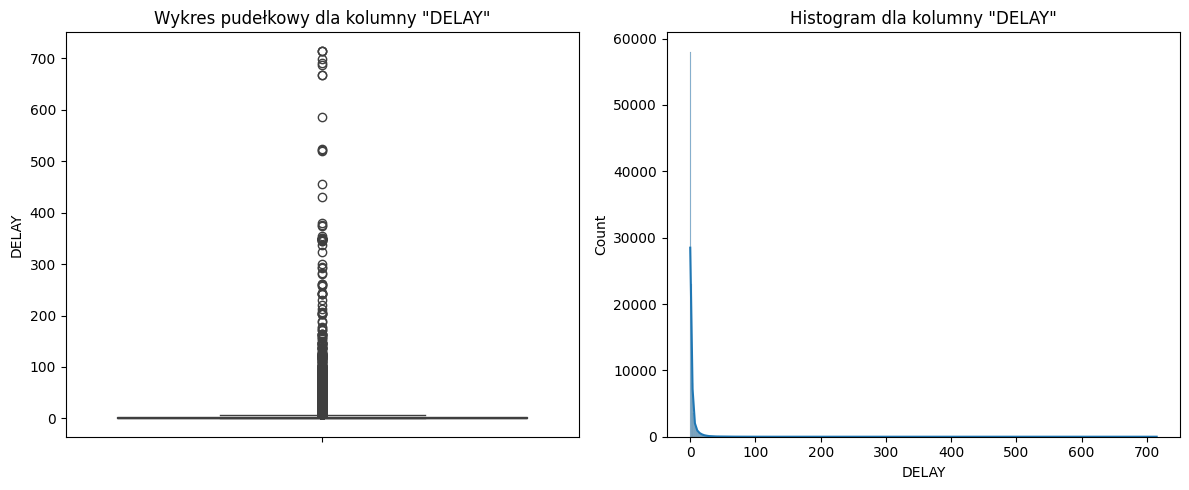

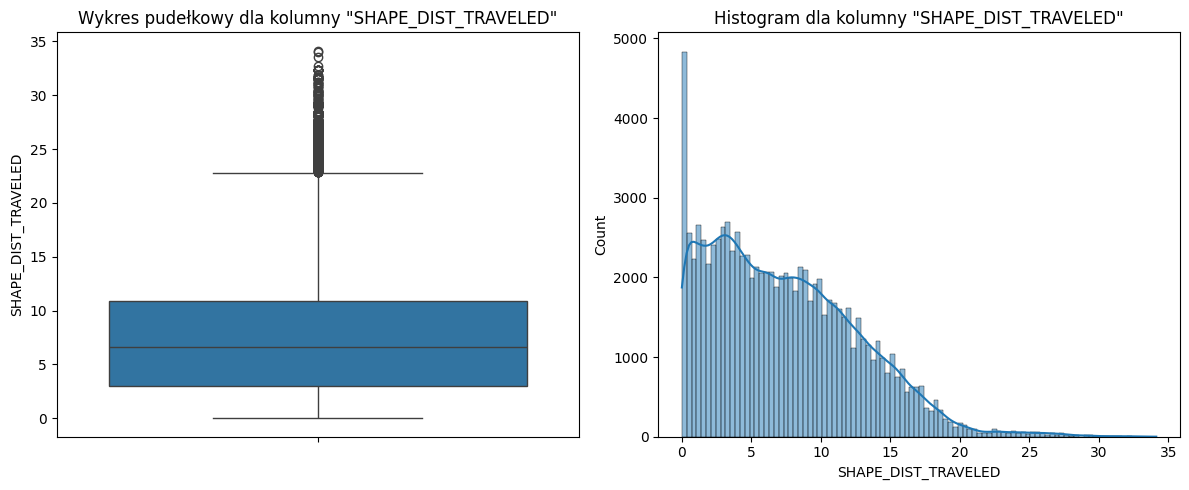

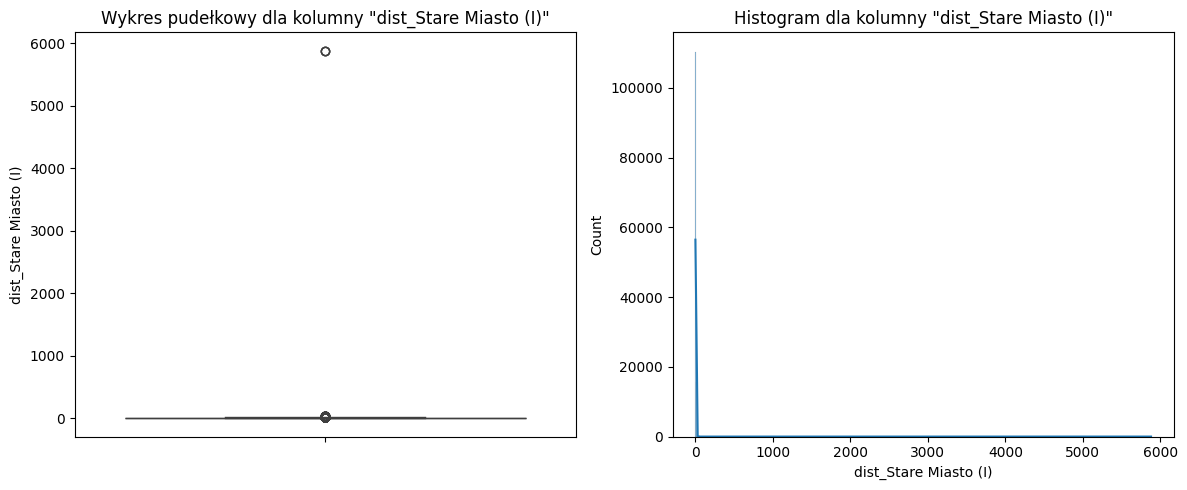

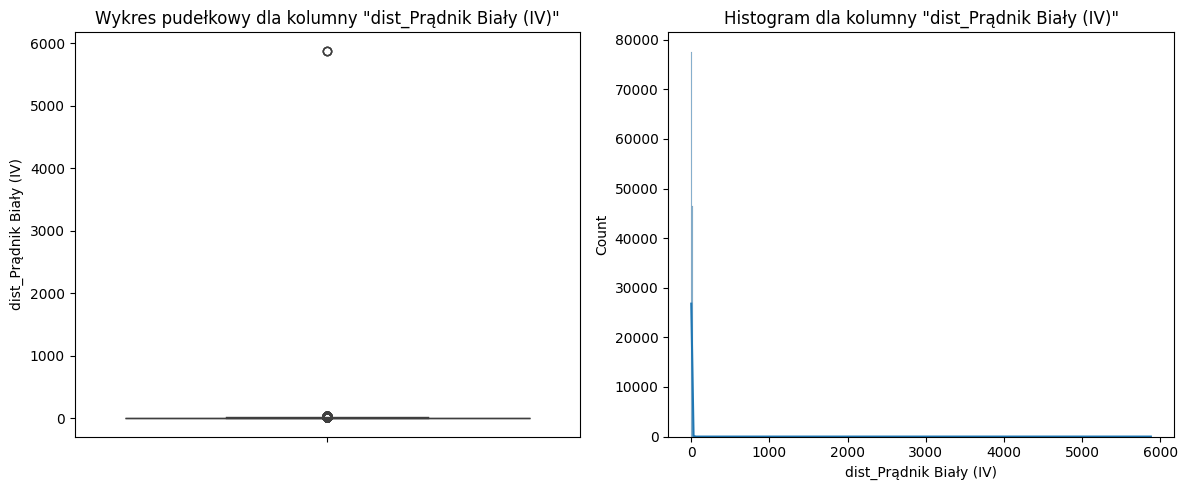

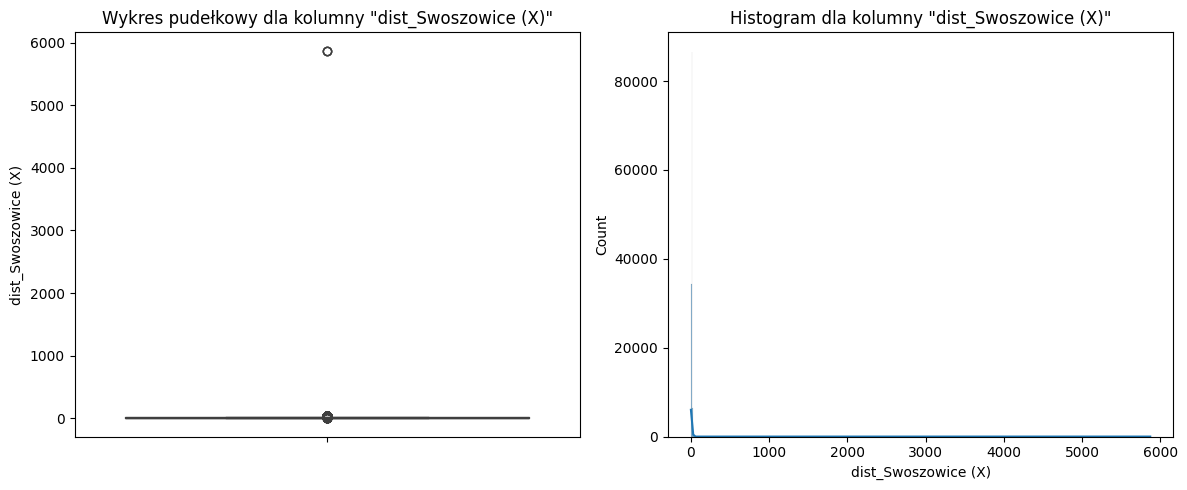

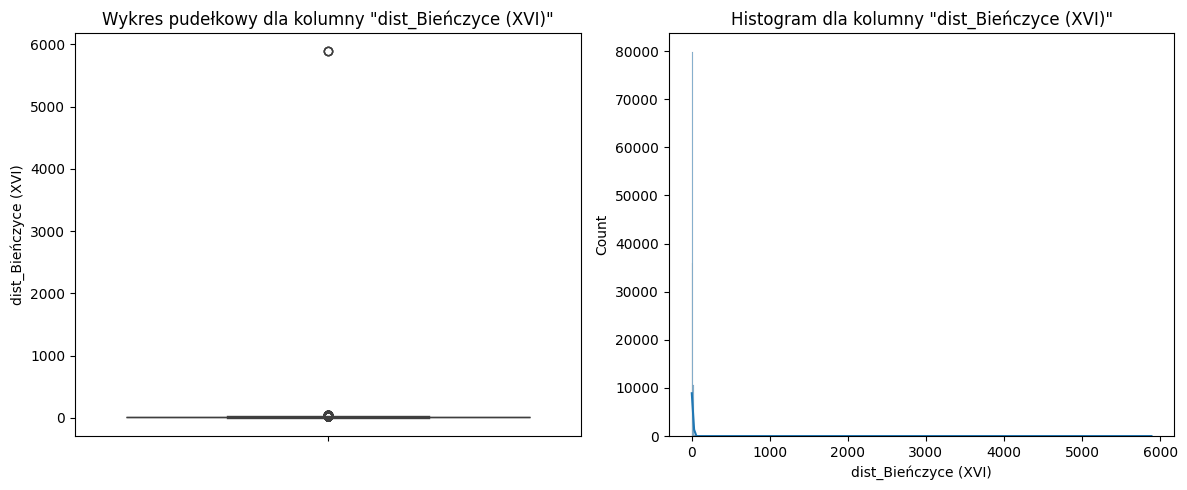

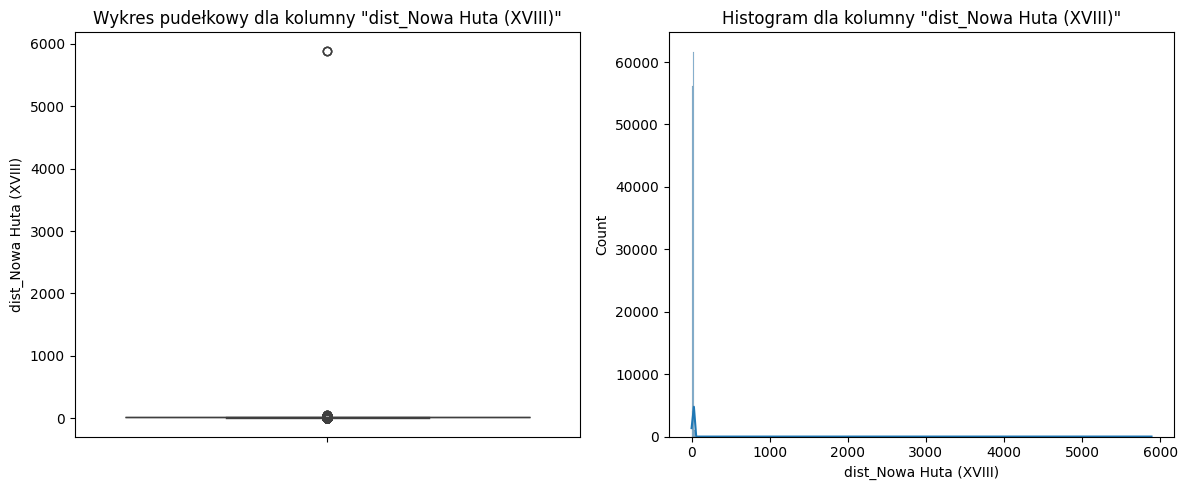

In [14]:
def plot_boxplots_and_histograms(df, features):
    for feature in features:
        plt.figure(figsize=(12, 5))

        # Boxplot
        plt.subplot(1, 2, 1)
        sns.boxplot(y=df[feature])
        plt.title(f'Wykres pudełkowy dla kolumny "{feature}"')

        # Histogram
        plt.subplot(1, 2, 2)
        sns.histplot(df[feature], kde=True)
        plt.title(f'Histogram dla kolumny "{feature}"')

        plt.tight_layout()
        plt.show()

plot_boxplots_and_histograms(df, ['DELAY', 'SHAPE_DIST_TRAVELED', 'dist_Stare Miasto (I)', 'dist_Prądnik Biały (IV)', 'dist_Swoszowice (X)', 'dist_Bieńczyce (XVI)', 'dist_Nowa Huta (XVIII)'])

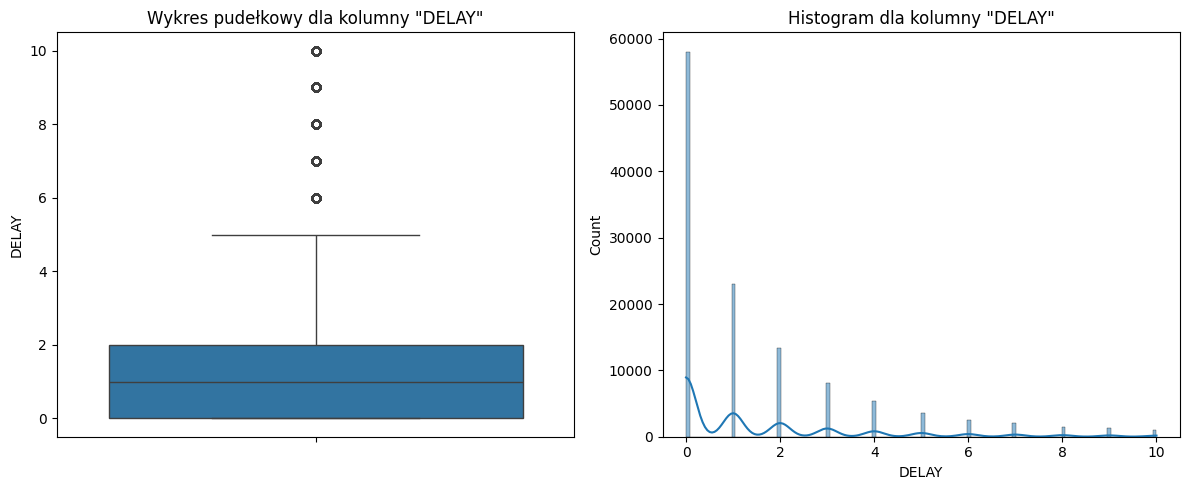

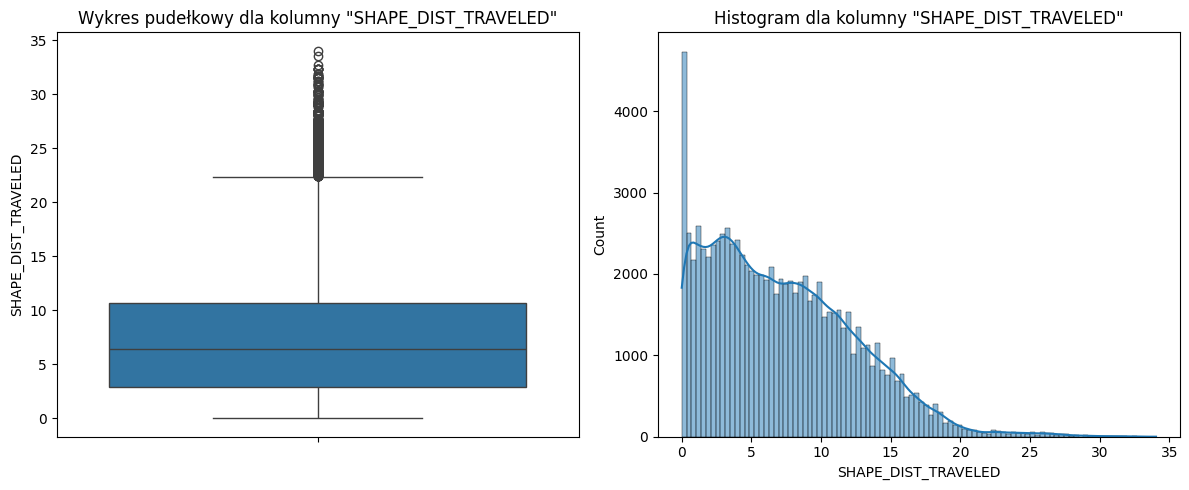

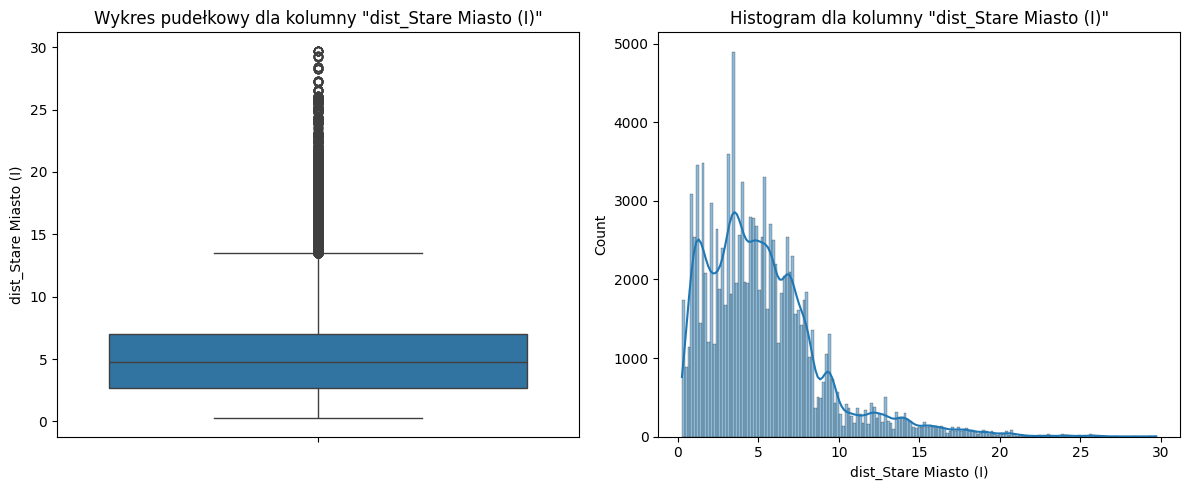

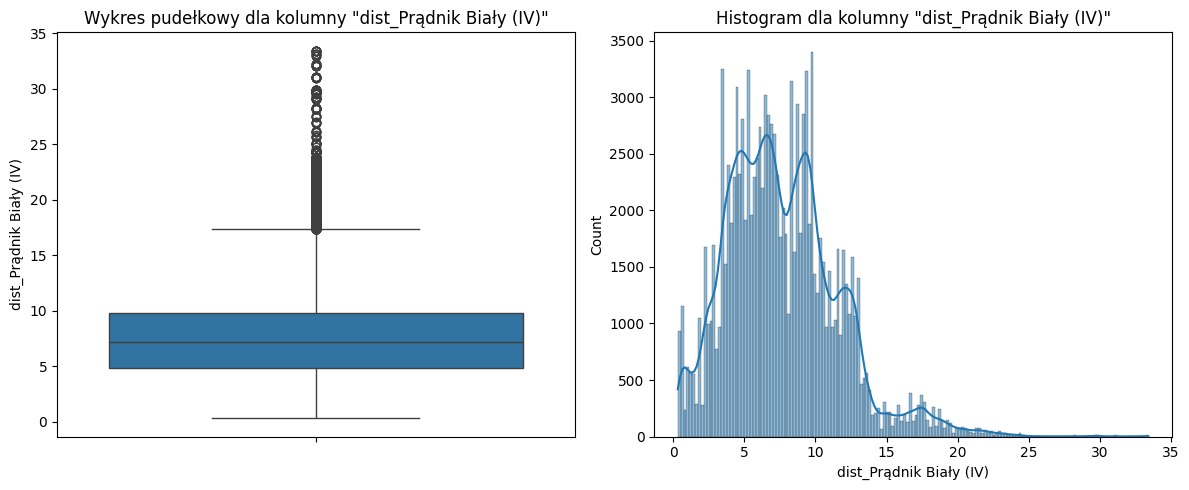

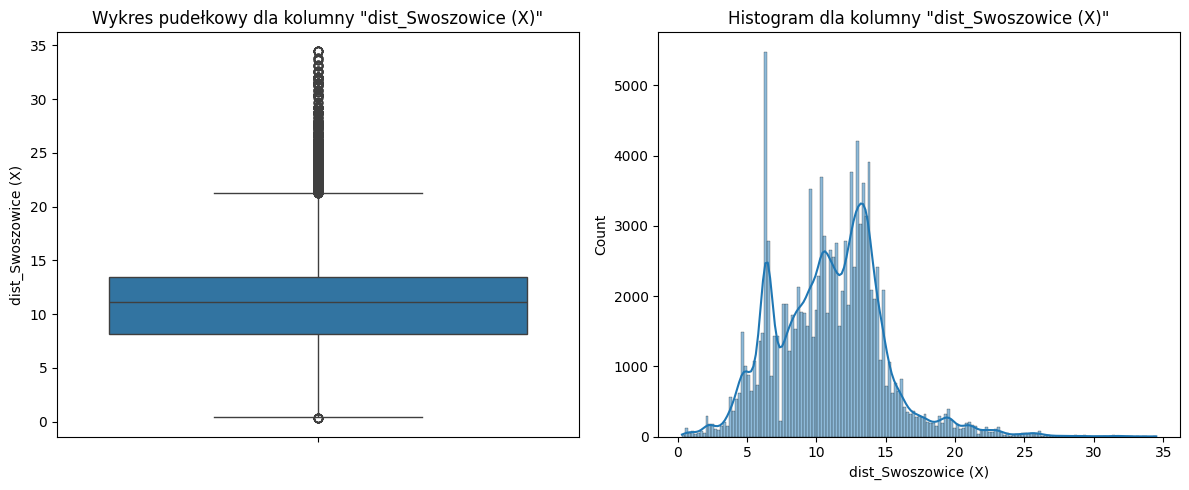

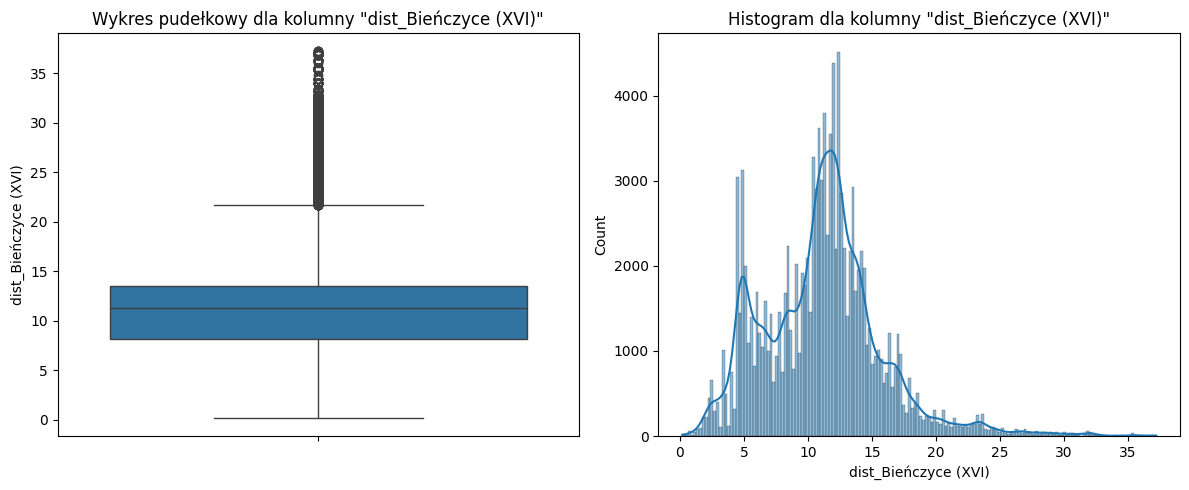

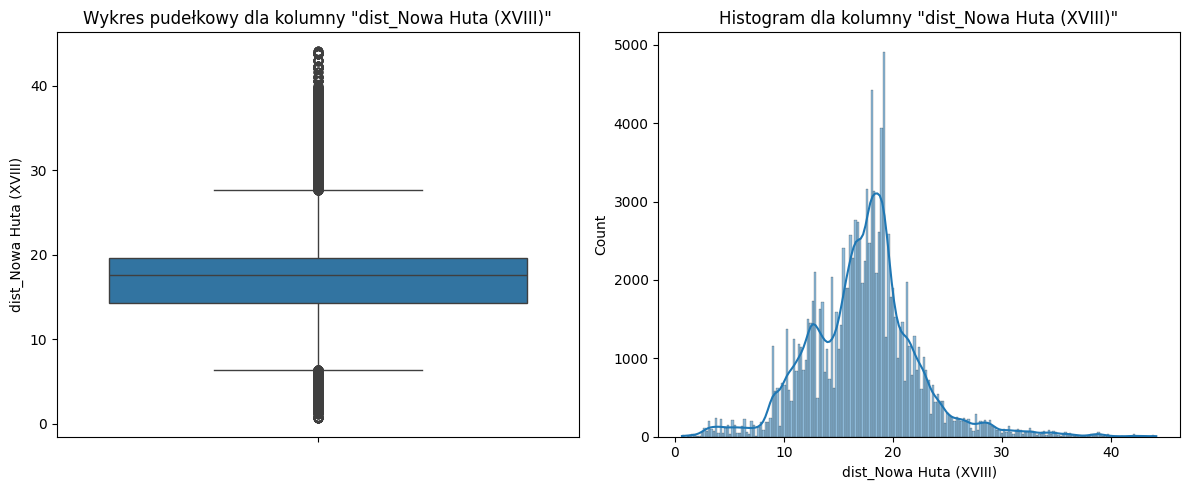

In [15]:
df_filtered = df[(df['DELAY'] <= 10) &
                 (df['dist_Stare Miasto (I)'] <= 50) &
                 (df['dist_Prądnik Biały (IV)'] <= 50) &
                 (df['dist_Swoszowice (X)'] <= 50) &
                 (df['dist_Bieńczyce (XVI)'] <= 50) &
                 (df['dist_Nowa Huta (XVIII)'] <= 50)]

plot_boxplots_and_histograms(df_filtered, ['DELAY', 'SHAPE_DIST_TRAVELED', 'dist_Stare Miasto (I)', 'dist_Prądnik Biały (IV)', 'dist_Swoszowice (X)', 'dist_Bieńczyce (XVI)', 'dist_Nowa Huta (XVIII)'])

### Charakterystyka Zmiennej DELAY
* Rozkład jest silnie prawoskośny. Zdecydowana większość obserwacji ma opóźnienie bliskie 0 lub 1.

* Mediana opóźnienia jest bardzo niska, bliska 1.0.

* Istnieją pojedyncze, ale ekstremalnie duże opóźnienia, sięgające ponad 700 minut. Te wartości odstające mają duży wpływ na średnią, ale mały na medianę. 
Wskazuje to na konieczność stosowania modeli odpornych na wartości odstające lub ich transformacji.

### Charakterystyka dist_Stare Miasto
* Rozkład jest silnie prawoskośny. Większość przystanków znajduje się bliżej Starego Miasta (Peak przy 5 km)

* Mediana wynosi ok. 4,8 km, wartości odstające do 30 km.

* Cecha jest silnie zróźnicowana, wskazuje na centrum miasta jako miejsce podwyższonego ryzyka wystąpienia opóźnienia.

### Charakterystyka pozostałych odległości.
* Rozkłady są biomodalne lub wielomodalne. Przystanki dzielą się na min. dwie grupy, blisko i daleko od danego punktu. Jest to cenna informacja, pozwalająca np. modelowi drzewiastemu na wykorzystywanie tego rozróżnienia (np. jeśli przystanek jest bliżej niż 10 km od Nowej Huty, ryzyko opóźnienia jest inne niż gdy jest dalej lub blizej)

In [16]:
df_max_delays= df.groupby('ROUTE_SHORT_NAME')['DELAY'].max().reset_index().sort_values(by='DELAY', ascending=False).head(10)
df_most_delayed_routes = df[df['ROUTE_SHORT_NAME'].isin(df_max_delays['ROUTE_SHORT_NAME'])]

df_mean_delays= df.groupby('ROUTE_SHORT_NAME')['DELAY'].mean().reset_index().sort_values(by='DELAY', ascending=False).head(10)
df_highest_mean_delay_routes = df[df['ROUTE_SHORT_NAME'].isin(df_mean_delays['ROUTE_SHORT_NAME'])]

df_median_delays= df.groupby('ROUTE_SHORT_NAME')['DELAY'].median().reset_index().sort_values(by='DELAY', ascending=False).head(10)
df_highest_median_delay_routes = df[df['ROUTE_SHORT_NAME'].isin(df_median_delays['ROUTE_SHORT_NAME'])]

In [17]:
def plot_boxplots_for_delays_by_route(dfs):
    for label, df in dfs.items():
        plt.figure(figsize=(12,6))
        sns.boxplot(x='ROUTE_SHORT_NAME',y='DELAY',data=df)
        plt.title(f'Wykres pudełkowy dla "{label}"')

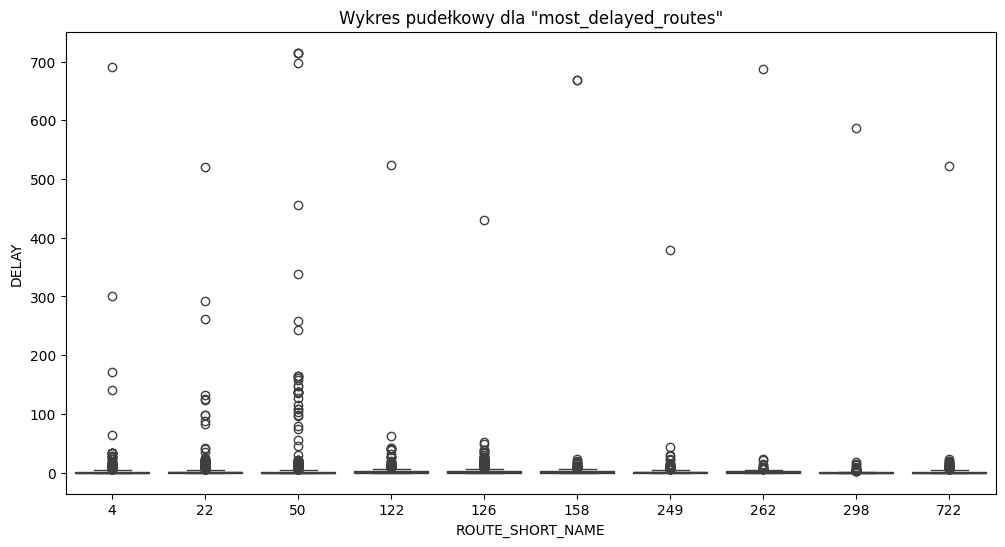

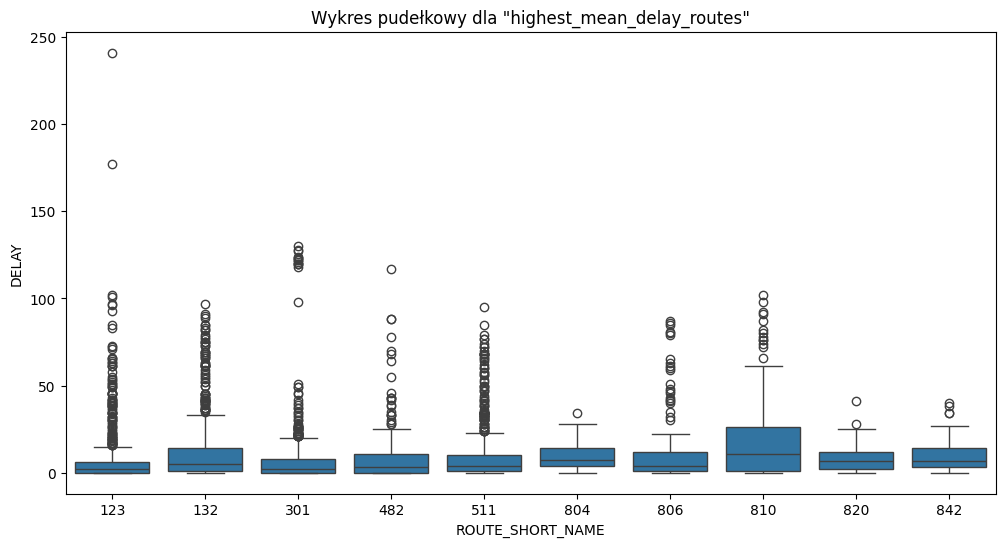

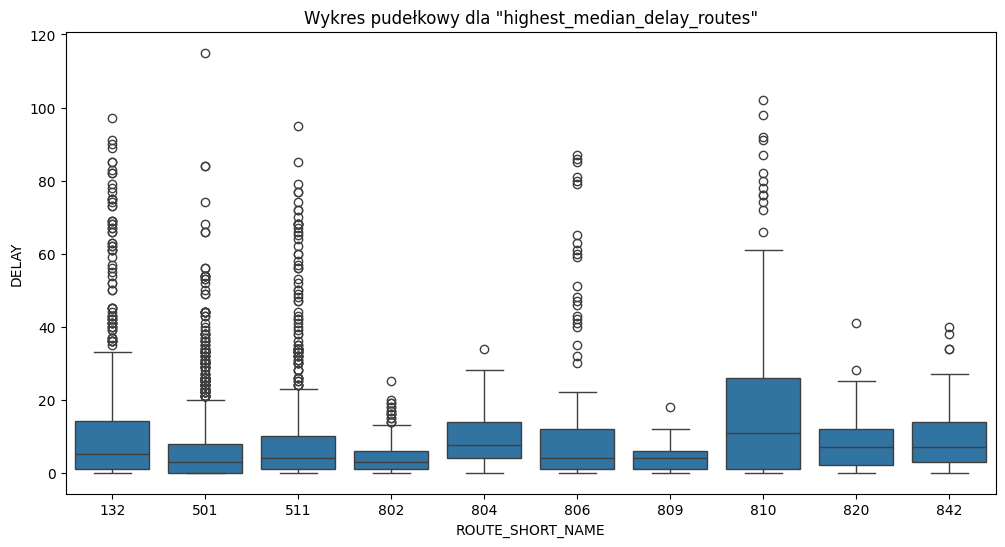

In [18]:
dfs = {'most_delayed_routes':df_most_delayed_routes, 'highest_mean_delay_routes':df_highest_mean_delay_routes, 'highest_median_delay_routes':df_highest_median_delay_routes}

plot_boxplots_for_delays_by_route(dfs)

# Badanie wpływu trasy (ROUTE_SHORT_NAME)

* Trasy takie jak np. 804, 806, 810 mają wyższe pudełka, co sugeruje, że są one bardziej opóźnione. Trasa 810 ma wyraźnie wyższą medianę i większy IQR niż większość innych tras.
* Trasy 50 i 122 mają wartości odstające sięgające do 600-700 minut, co sugeruje, że mają one największe ryzyko wystąpienia bardzo dużych opóźnień.

## Wniosek: 
Trasa jest kluczowym predyktorem. Należy traktować zmienną ROUTE_SHORT_NAME jako zmienną kategoryczną i traktować niektóre trasy (np. 810) jako wysokiego ryzyka w modelu.

In [35]:
def plot_scatterplots_for_distance_vs_delay(df, distance_columns):
    for col in distance_columns:
        plt.figure(figsize=(15, 8)) # Zmniejsz rozmiar figsize dla lepszej czytelności
        sns.scatterplot(data=df, x='DELAY', y=col)

        # Ustawienie limitu dla osi Y do 2000 jednostek
        plt.ylim(0, 30) 

        plt.title(f'Opóźnienie vs. Odległość do {col} (Y < 30)')
        plt.show()

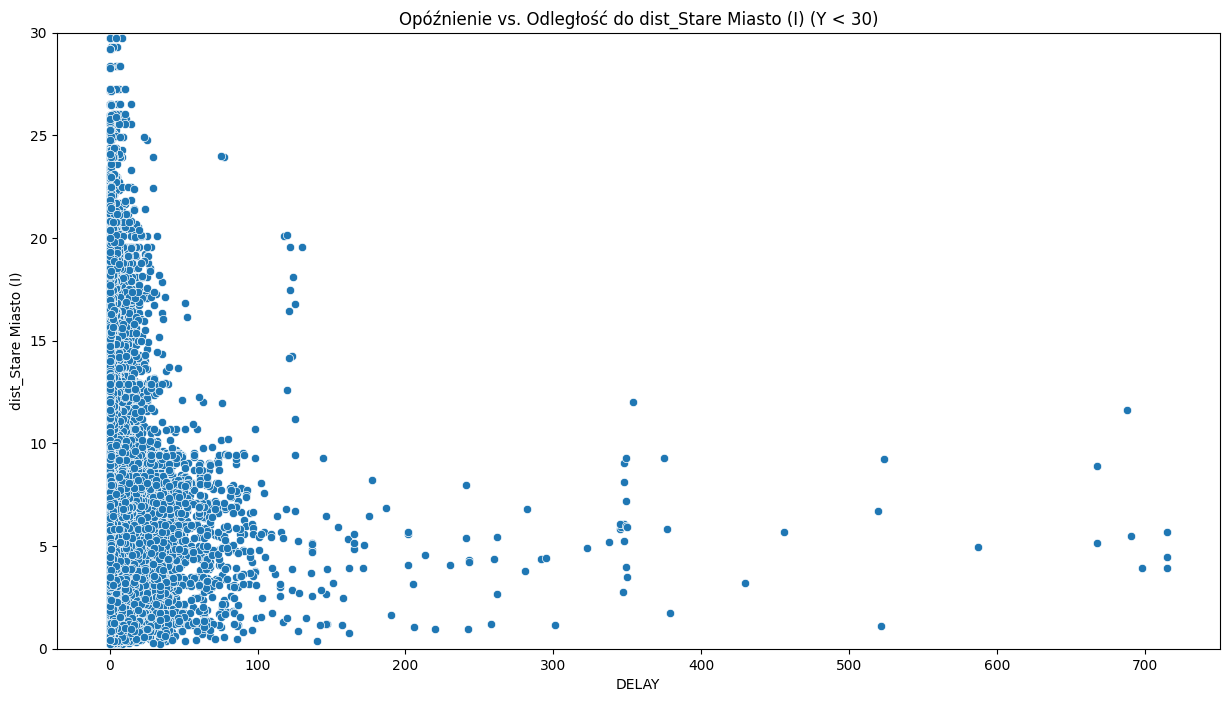

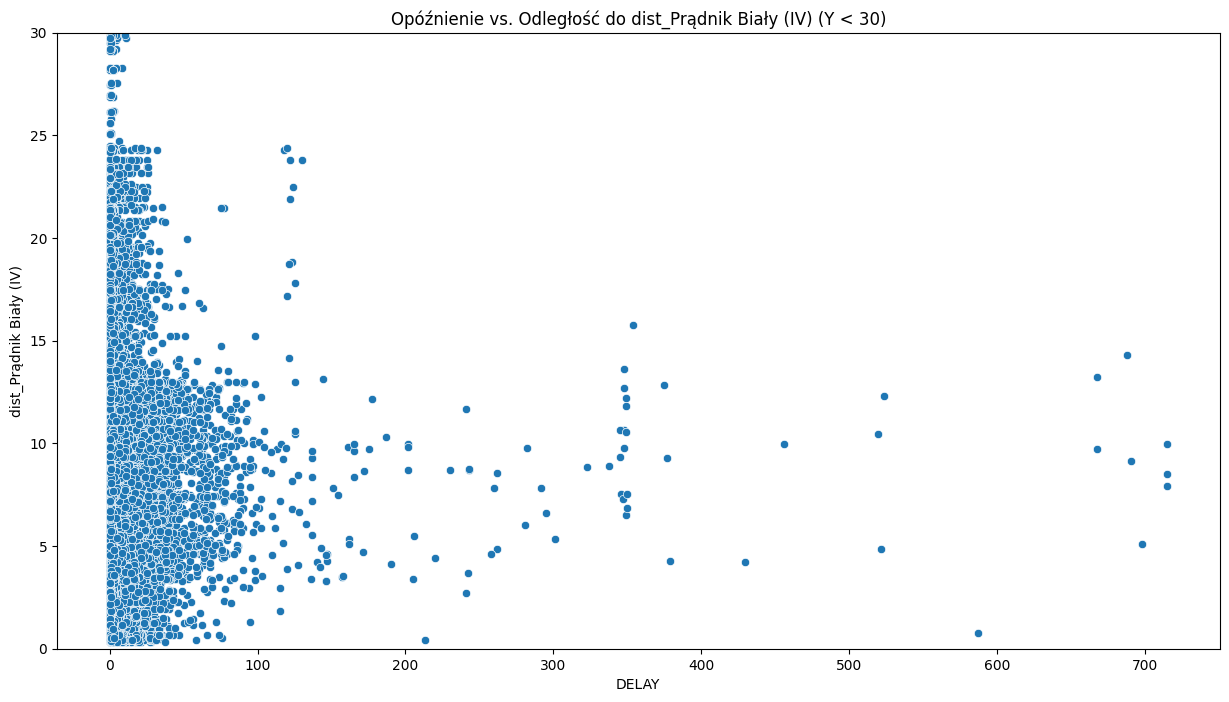

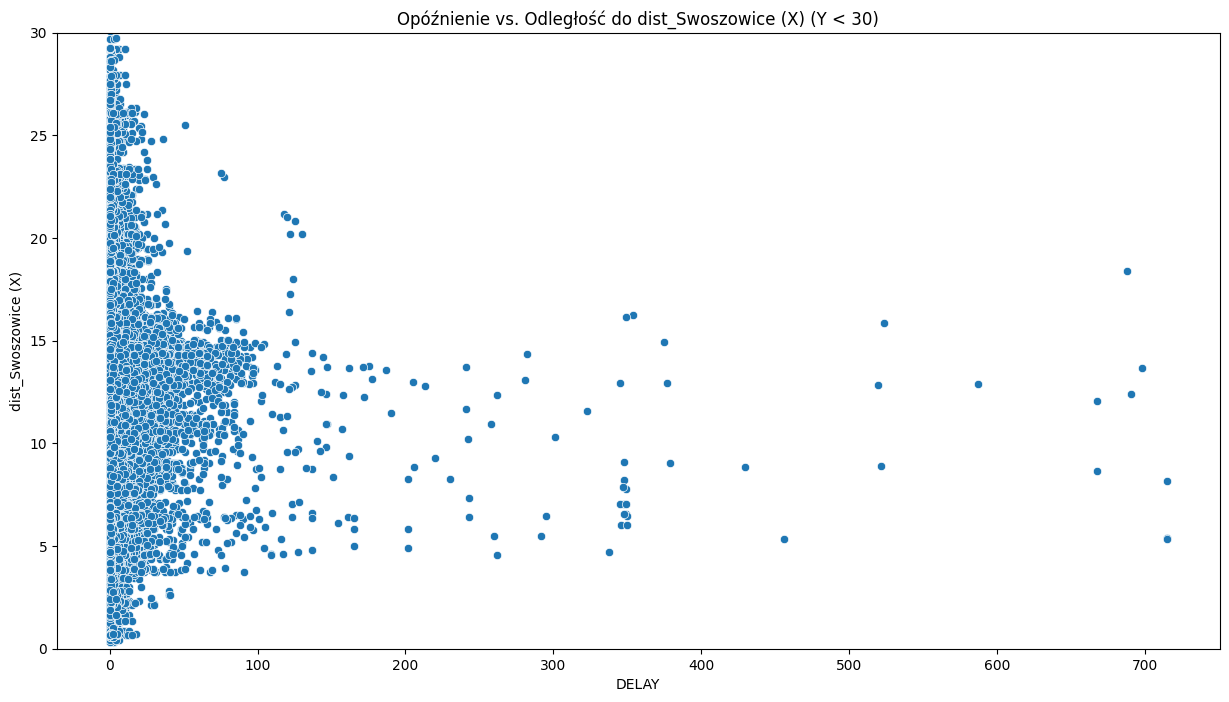

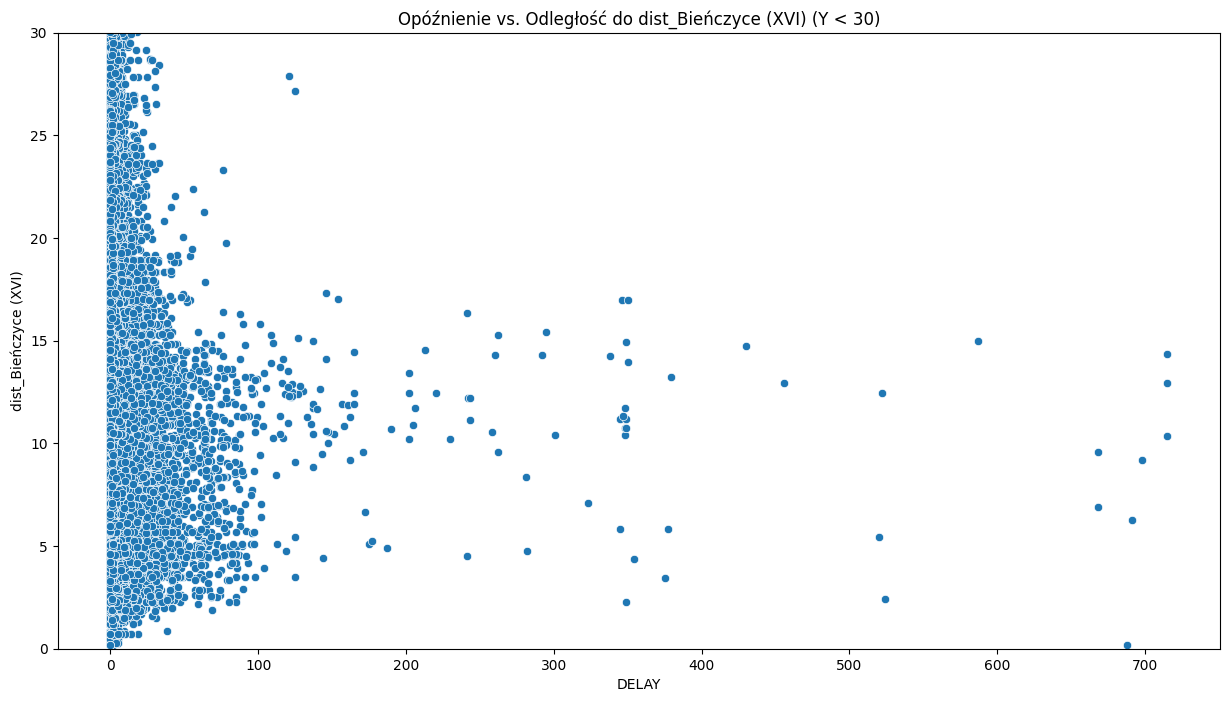

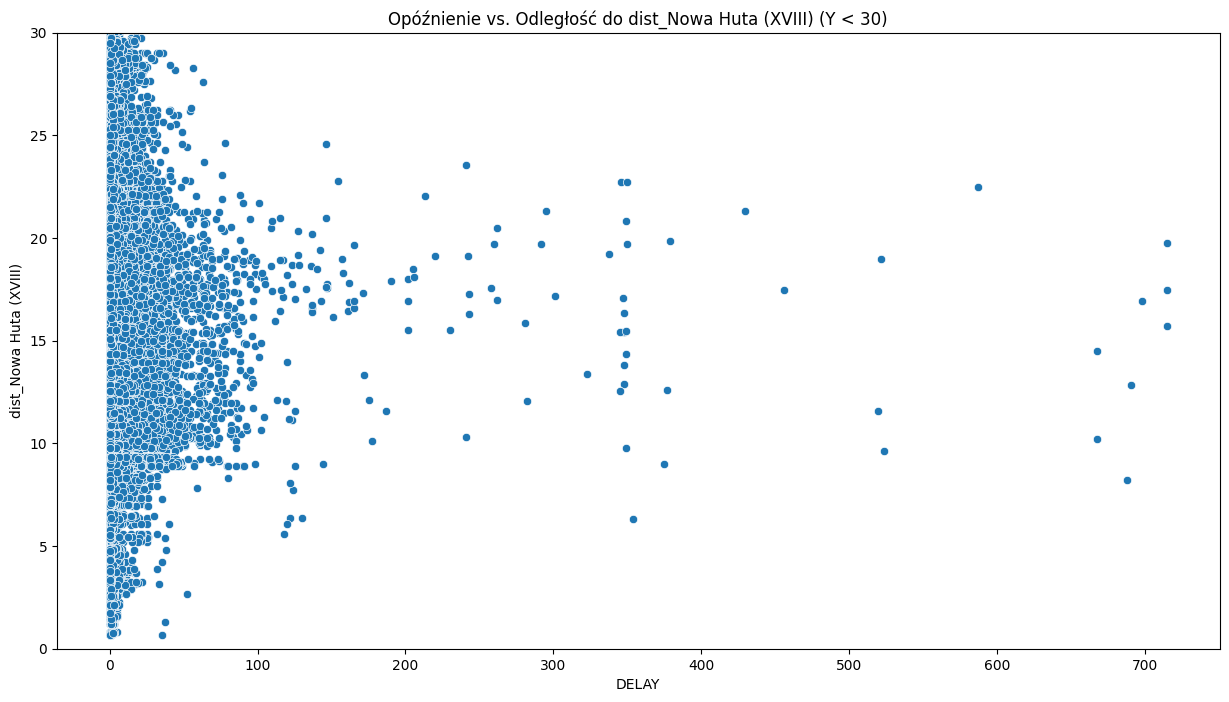

In [ ]:
plot_scatterplots_for_distance_vs_delay(df, ['dist_Stare Miasto (I)', 'dist_Prądnik Biały (IV)', 'dist_Swoszowice (X)', 'dist_Bieńczyce (XVI)', 'dist_Nowa Huta (XVIII)'])

### Rozkłady odległości:

* Wszystkie wykresy pokazują silną koncentracjię danych przy małych opóźnieniach i pewnych odległościach do danego punktu. 

* Wraz ze wzrostem odległości do Starego Miasta, opóźnienia rzadziej przyjmują skrajnie wysokie wartości.

* Przy małej odległości do centrum miasta odnotowuje się największą zmienność i największe wartości opóźnień.

# Badanie wpływu dnia tygodnia (WEEKDAY)

In [21]:
df['WEEKDAY'] = df['ACTUAL_ARRIVAL'].dt.day_name()
df['WEEKDAY_NUMBER'] = df['ACTUAL_ARRIVAL'].dt.weekday

Text(0.5, 1.0, 'Wykres słupkowy dla średniej wartości zmiennej "DELAY" w zależności od dnia tygodnia')

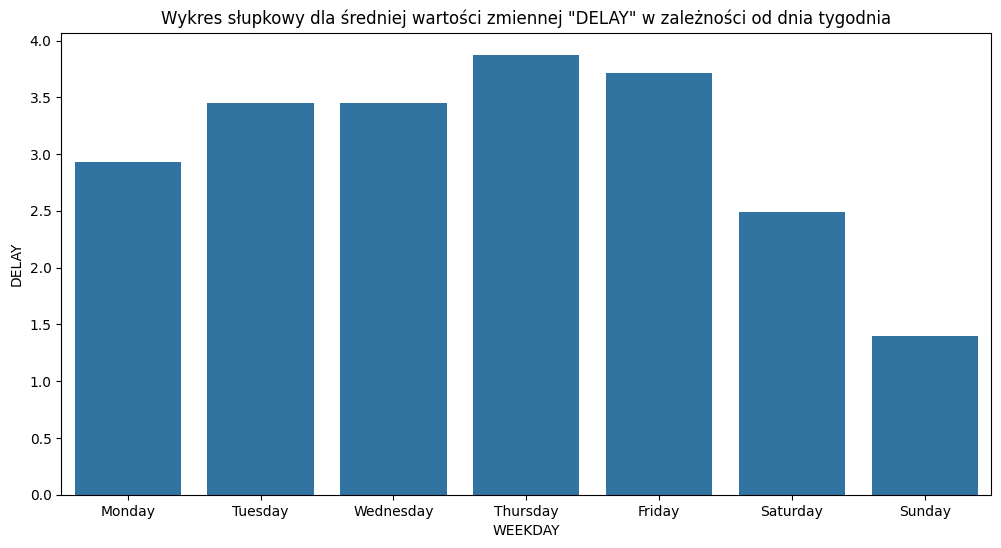

In [22]:
plt.figure(figsize=(12,6))
sns.barplot(x='WEEKDAY', y='DELAY', data=df, errorbar=None, estimator=np.mean, order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.title(f'Wykres słupkowy dla średniej wartości zmiennej "DELAY" w zależności od dnia tygodnia')

### Średnie opóźnienia
* Ponieważ średnia jest znacznie wyższa niż mediana i waha się, wskazuje to, że częstotliwość i wielkość dużych opóźnień zależy od dnia tygodnia.
* Najmniejsza Średnia: Niedziela i Sobota. (logiczne, ruch jest wtedy mniejszy.)
* Największa Średnia: Czwartek i Piątek. Koniec tygodnia = większe natężenie ruchu. Generuje najwyższe średnie opóźnienia.

W dni powszednie średnie opóźnienie jest mniejsze (nieznacznie).

Text(0.5, 1.0, 'Wykres słupkowy dla maksymalnej wartości zmiennej "DELAY" w zależności od dnia tygodnia')

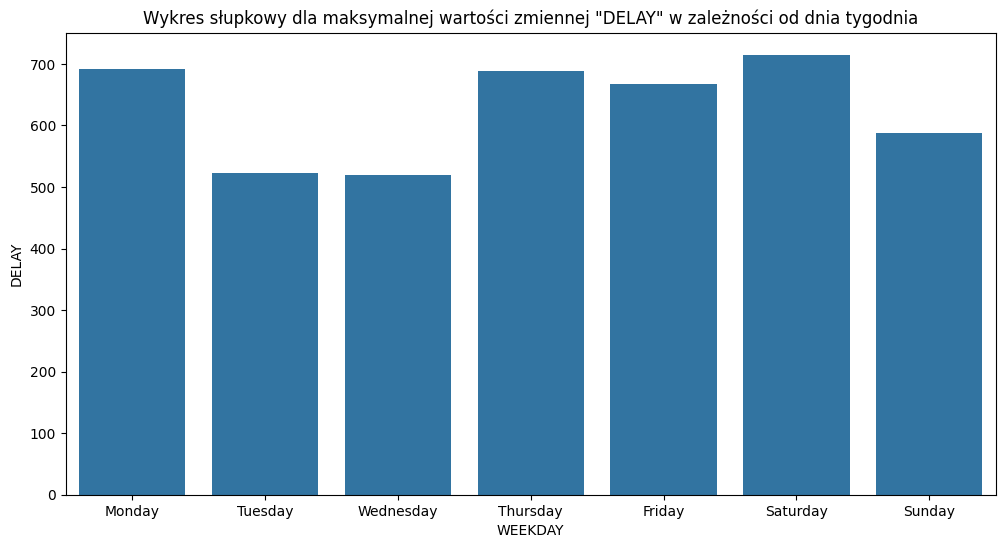

In [23]:
plt.figure(figsize=(12,6))
sns.barplot(x='WEEKDAY', y='DELAY', data=df, errorbar=None, estimator="max", order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.title(f'Wykres słupkowy dla maksymalnej wartości zmiennej "DELAY" w zależności od dnia tygodnia')

### Wnioski 
Dzień Tygodnia jest ważnym predyktorem dla ŚREDNIEGO opóźnienia, ale nie dla TYPOWEGO opóźnienia. Model powinien traktować dni powszednie (szczególnie czwartek/piątek) jako okresy podwyższonego ryzyka dużych opóźnień.

Text(0.5, 1.0, 'Wykres pudełkowy dla wartości zmiennej "DELAY" w zależności od dnia tygodnia')

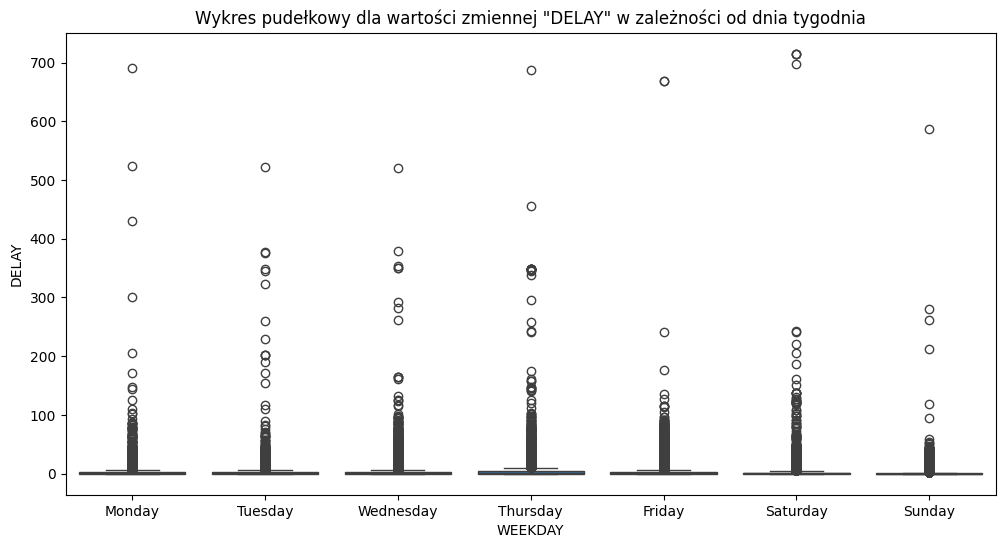

In [24]:
plt.figure(figsize=(12,6))
sns.boxplot(x='WEEKDAY',y='DELAY',data=df, order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.title(f'Wykres pudełkowy dla wartości zmiennej "DELAY" w zależności od dnia tygodnia')

# Badanie wpływu pory dnia

In [25]:
# Getting hours and minutes rounded to 30 minutes from ACTUAL_ARRIVAL
df['ACTUAL_ARRIVAL_ROUNDED'] = df['ACTUAL_ARRIVAL'].dt.round('30min').dt.strftime('%H:%M')

Text(0.5, 1.0, 'Wykres słupkowy dla średniej wartości zmiennej "DELAY" w zależności od godziny rzeczywistego przybycia')

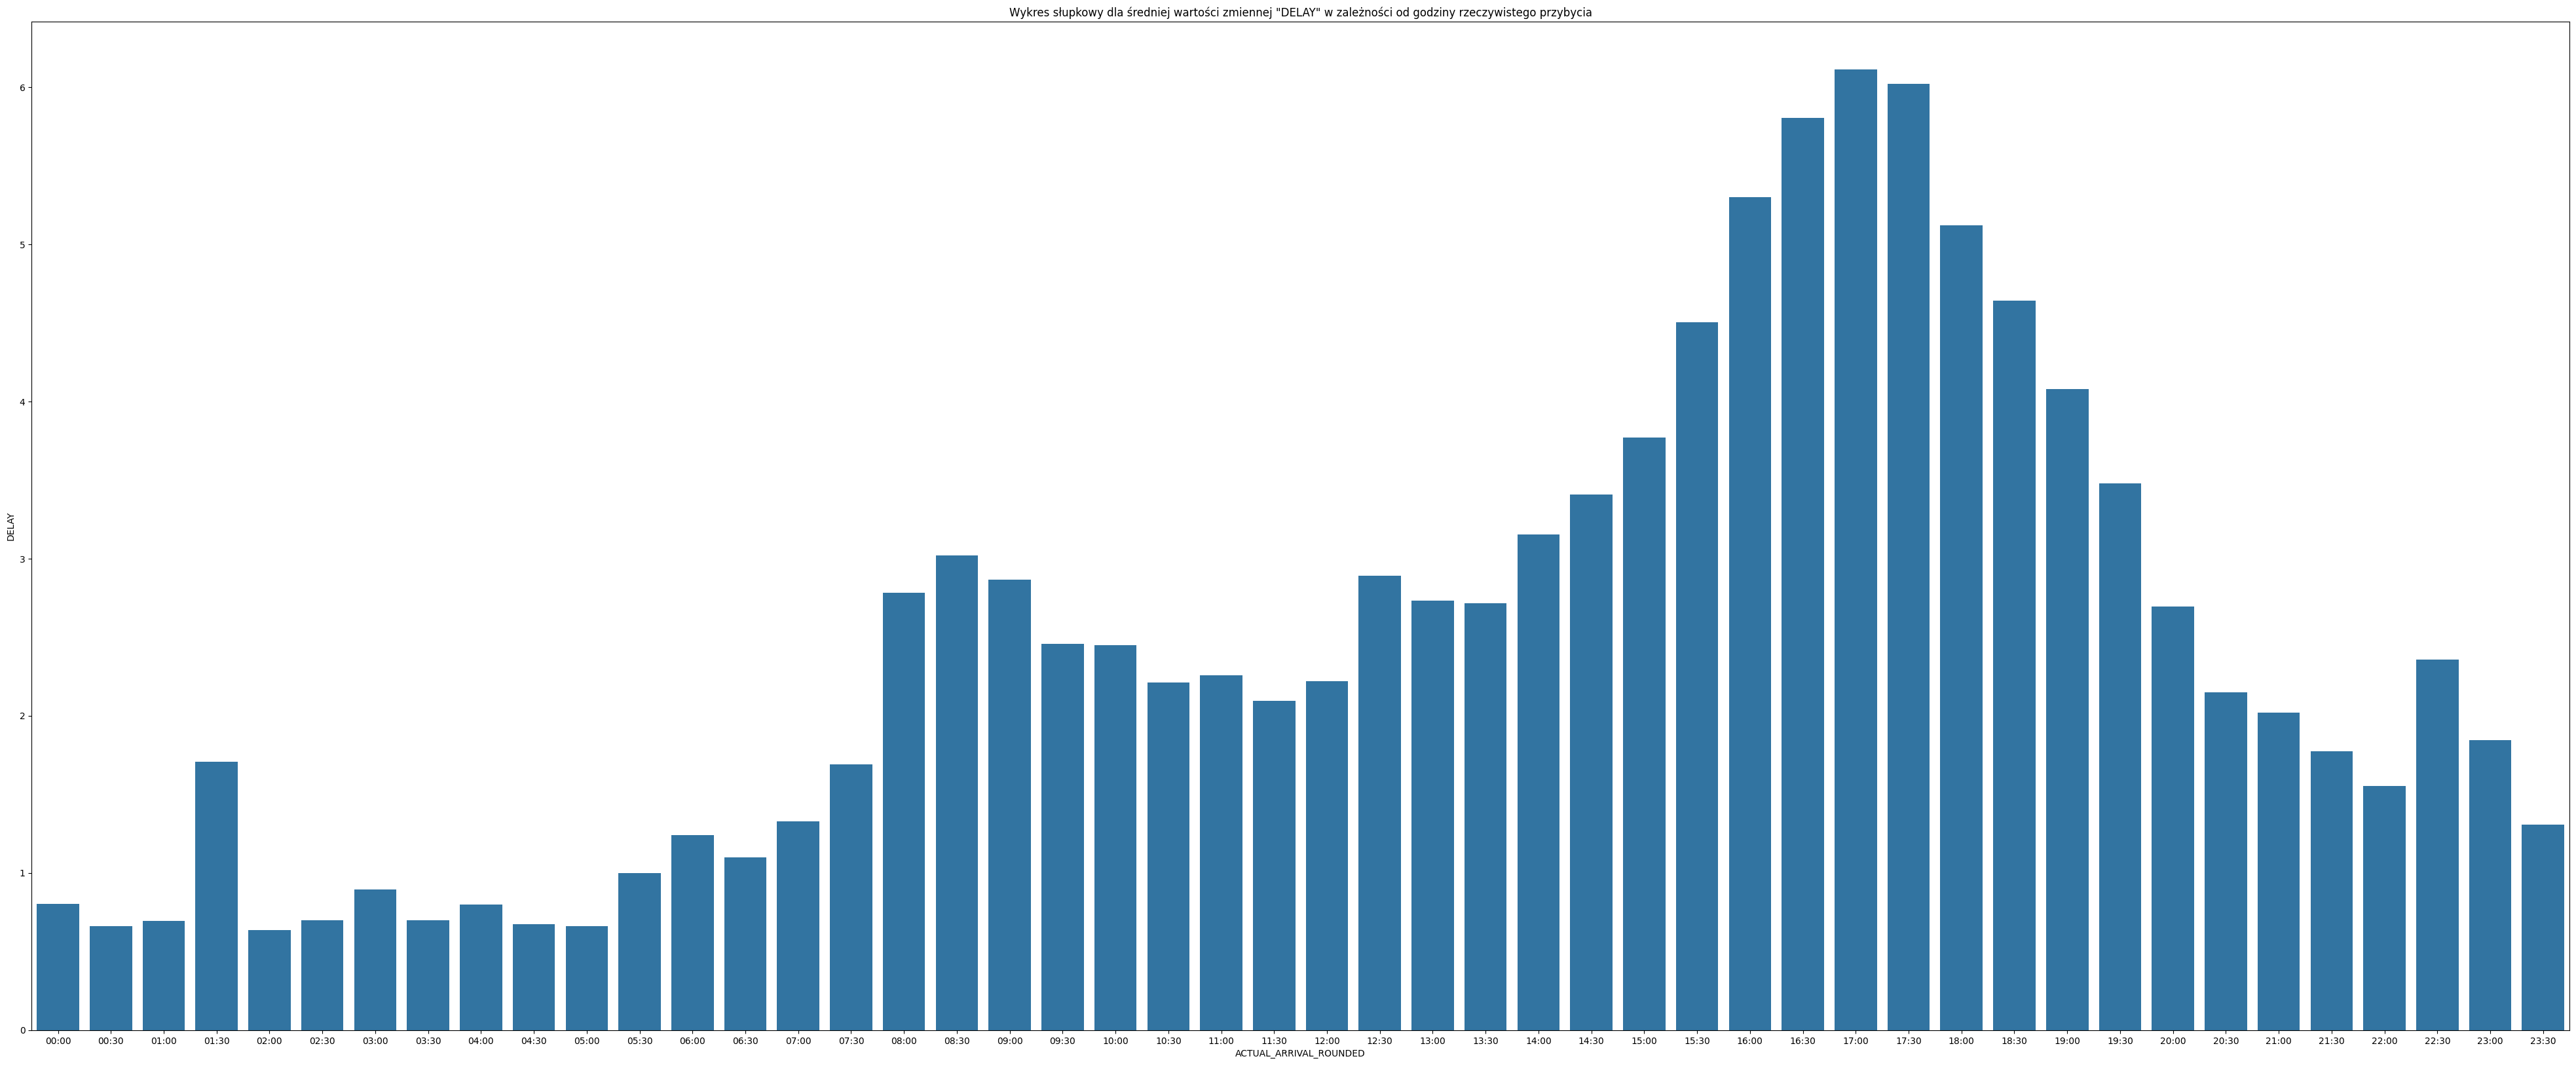

In [26]:
plt.figure(figsize=(50,20))
sns.barplot(x='ACTUAL_ARRIVAL_ROUNDED', y='DELAY', data=df, errorbar=None, estimator="mean", order=sorted(df['ACTUAL_ARRIVAL_ROUNDED'].unique()))
plt.title('Wykres słupkowy dla średniej wartości zmiennej "DELAY" w zależności od godziny rzeczywistego przybycia')

Text(0.5, 1.0, 'Wykres słupkowy dla maksymalnej wartości zmiennej "DELAY" w zależności od godziny rzeczywistego przybycia')

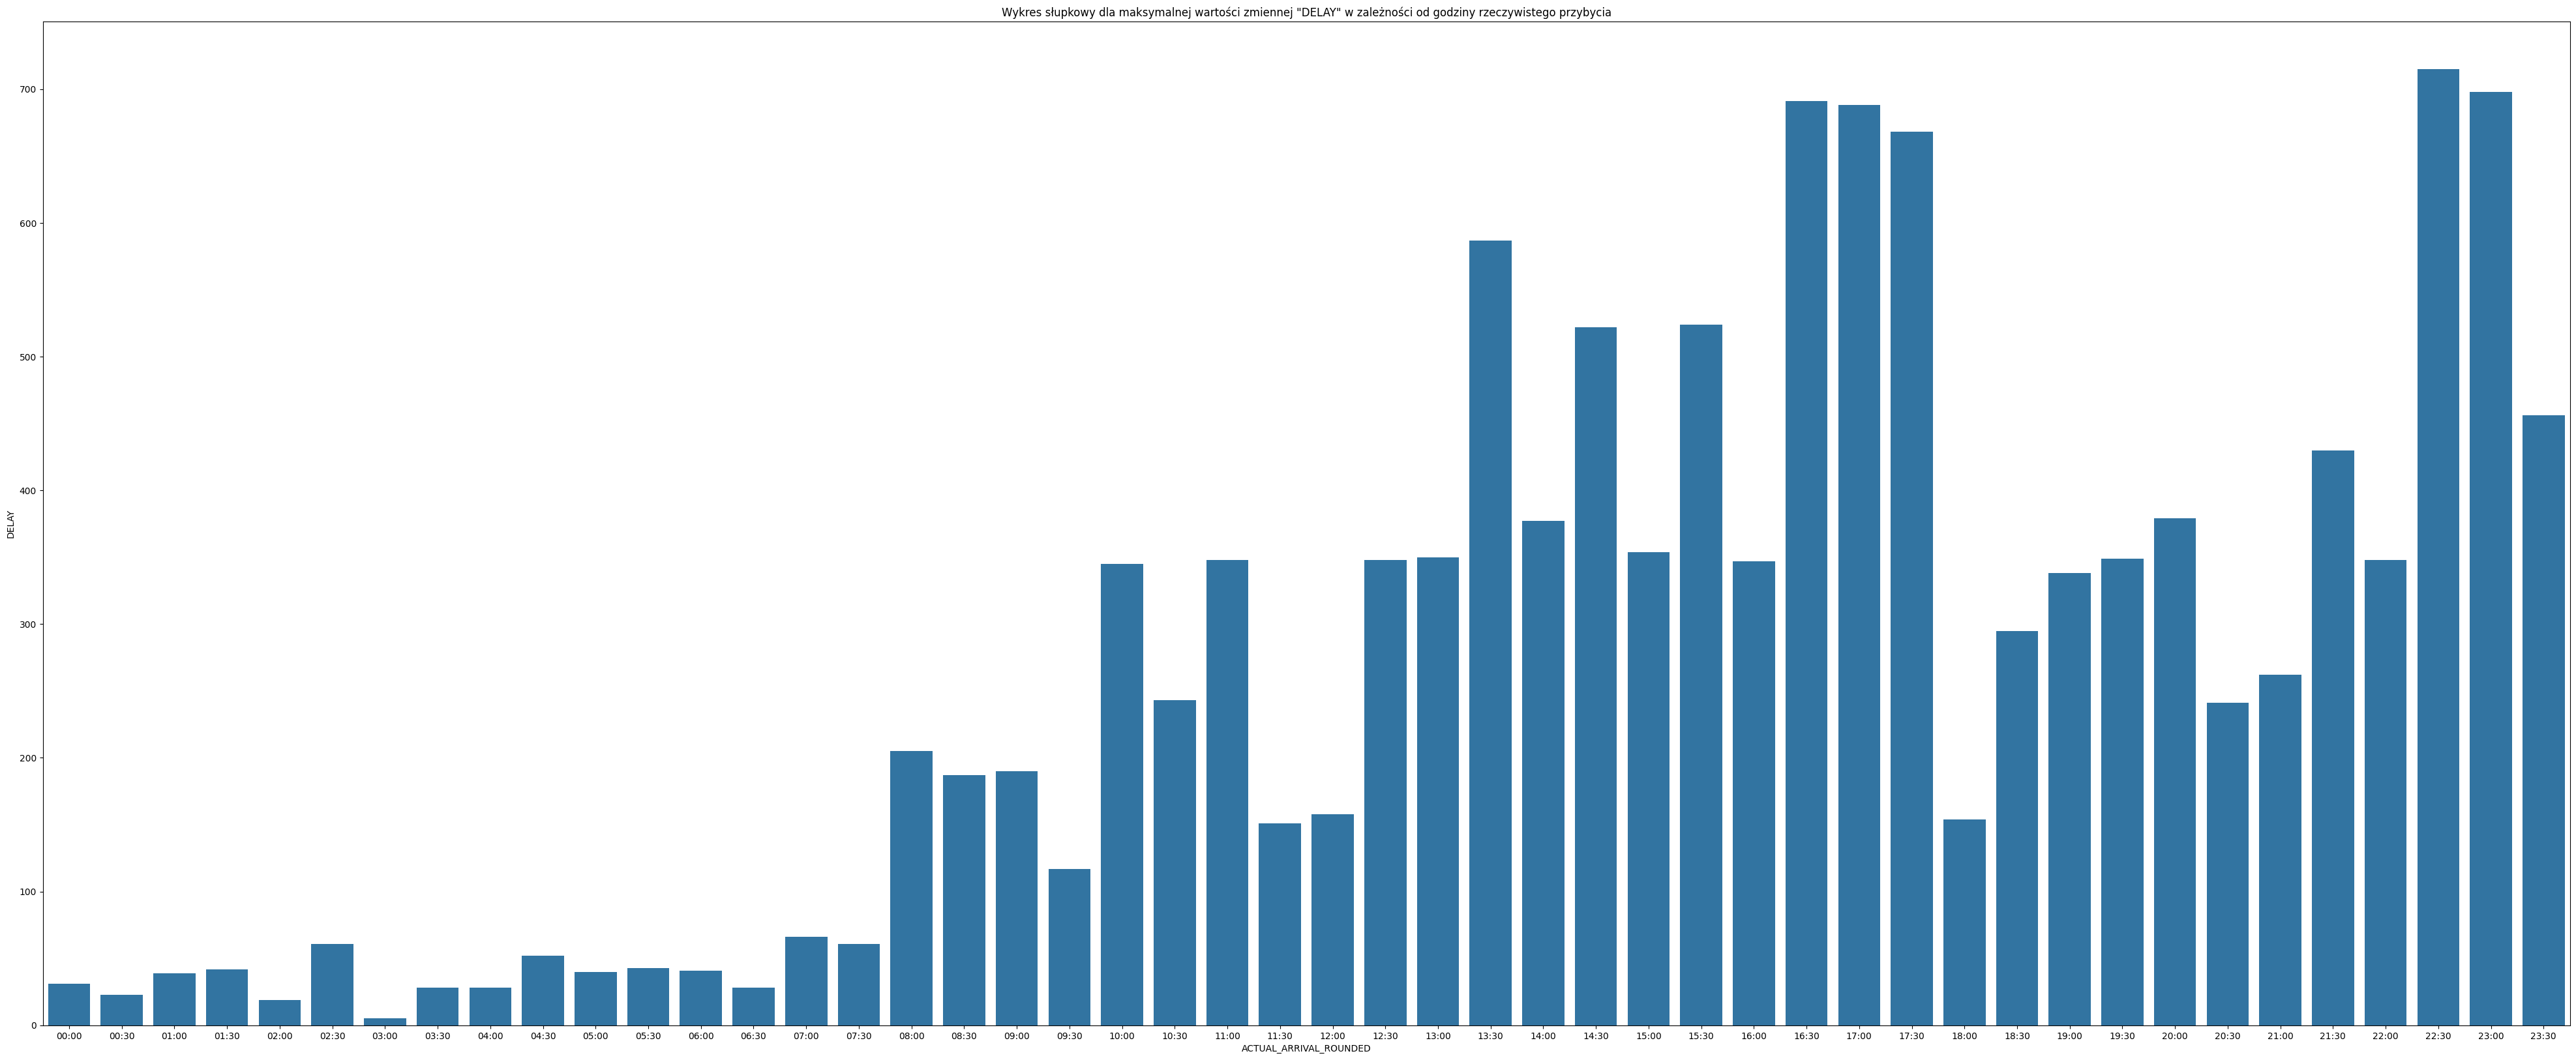

In [27]:
plt.figure(figsize=(50,20))
sns.barplot(x='ACTUAL_ARRIVAL_ROUNDED', y='DELAY', data=df, errorbar=None, estimator="max", order=sorted(df['ACTUAL_ARRIVAL_ROUNDED'].unique()))
plt.title('Wykres słupkowy dla maksymalnej wartości zmiennej "DELAY" w zależności od godziny rzeczywistego przybycia')

Text(0.5, 1.0, 'Wykres słupkowy dla odchylenia standardowego zmiennej "DELAY" w zależności od godziny rzeczywistego przybycia')

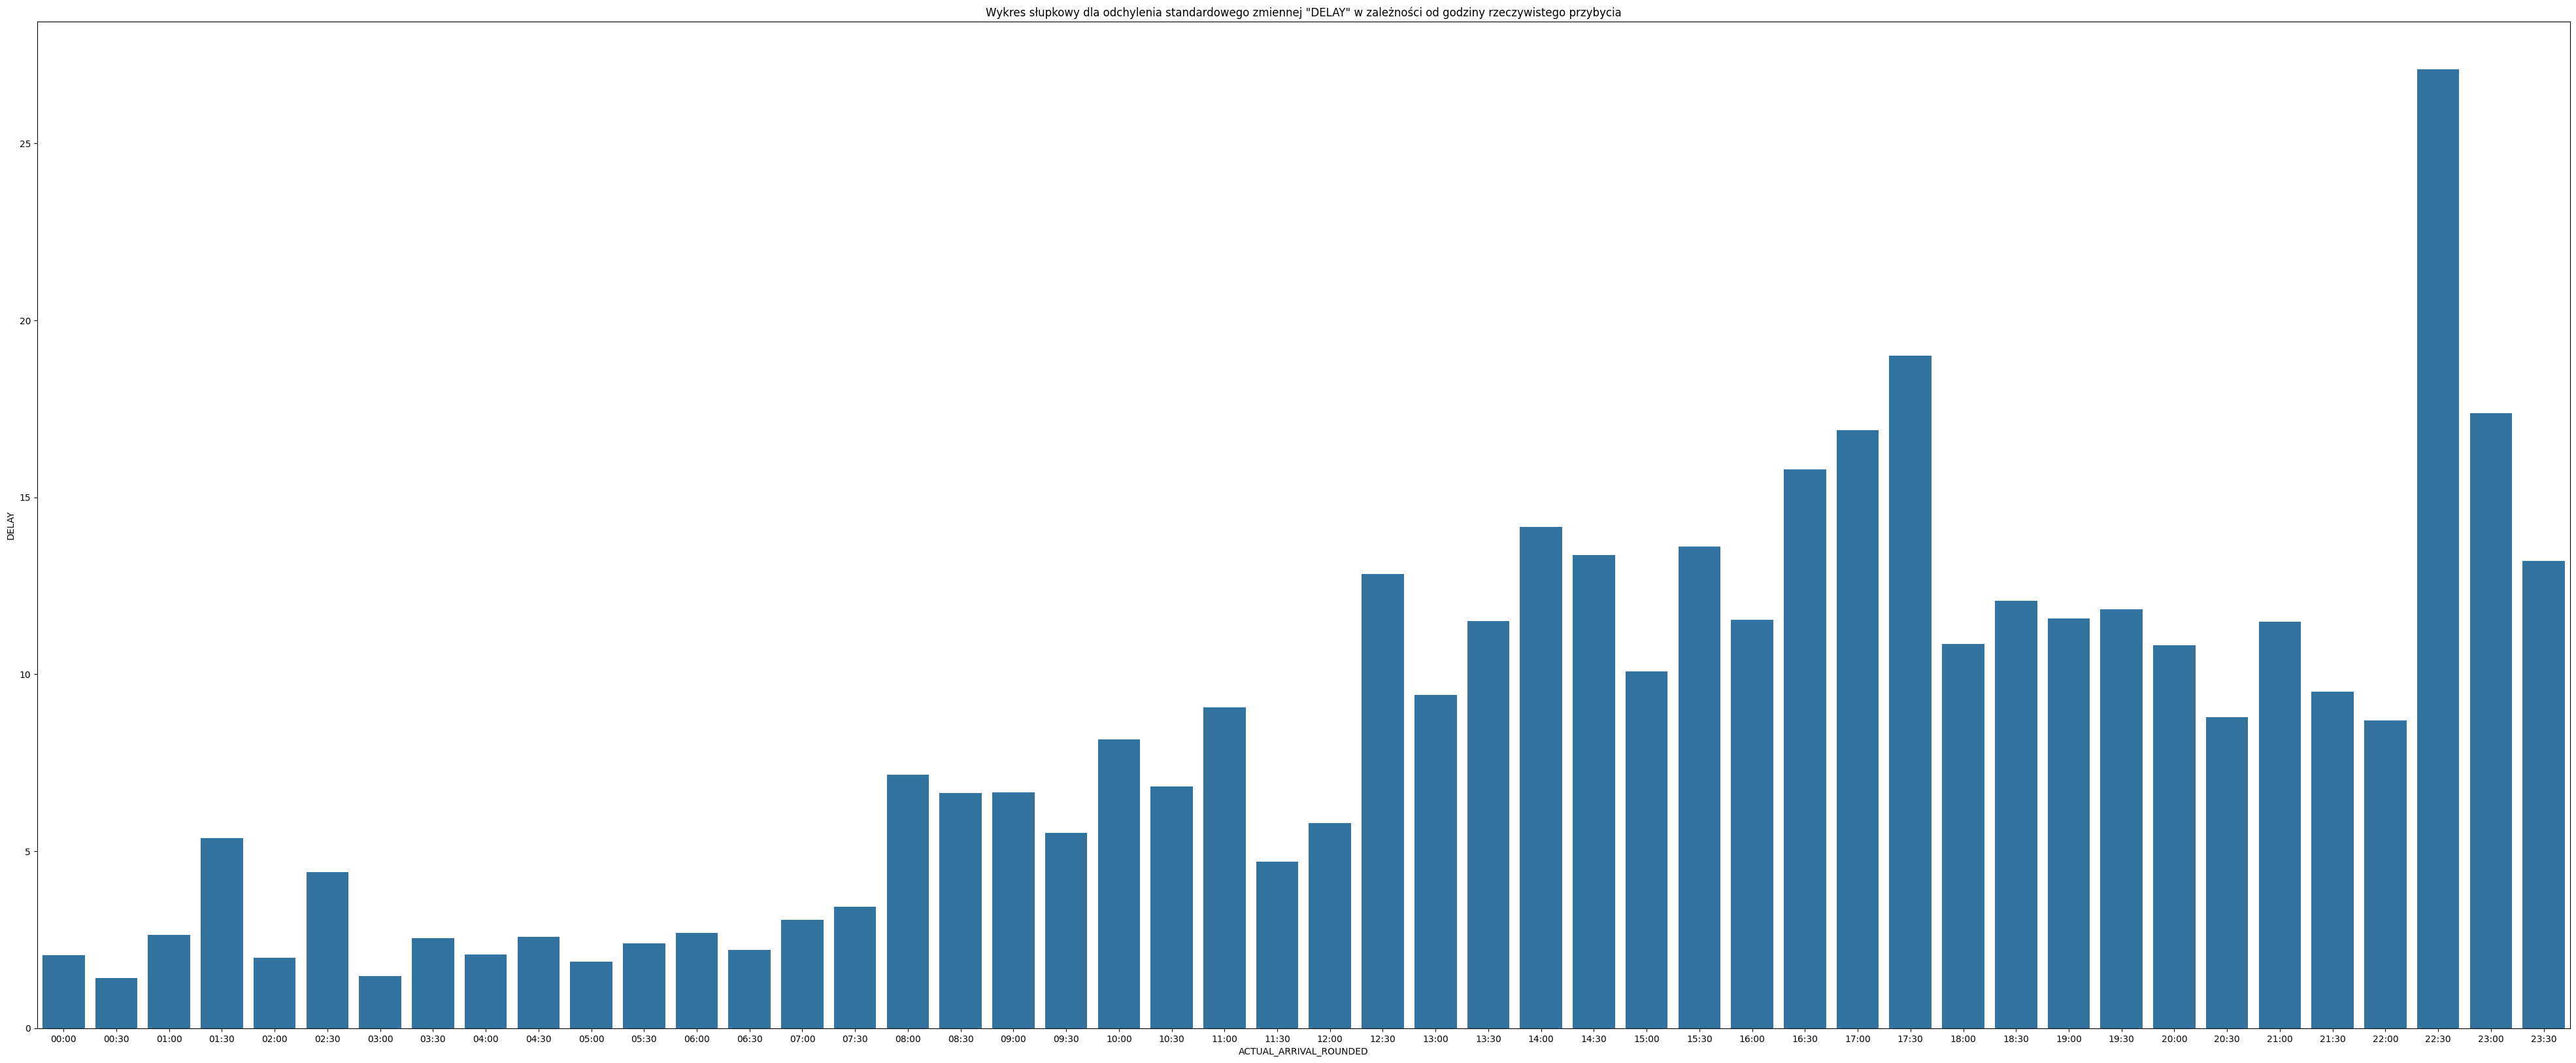

In [28]:
plt.figure(figsize=(50,20))
sns.barplot(x='ACTUAL_ARRIVAL_ROUNDED', y='DELAY', data=df, errorbar=None, estimator="std", order=sorted(df['ACTUAL_ARRIVAL_ROUNDED'].unique()))
plt.title('Wykres słupkowy dla odchylenia standardowego zmiennej "DELAY" w zależności od godziny rzeczywistego przybycia')

* Wykres słupkowy średniej opóźnienia w zależności od godziny przyjazdu ujawnia silny wzorzec cykliczny:
    * Peak Poranny: Średnie opóźnienie wzrasta podczas porannego szczytu (między 07:00 a 09:00), osiągając lokalne maksimum.
    * Spadek Południowy: Opóźnienia spadają w ciągu dnia (w okolicach 12:00-14:00).
    * Peak Popołudniowy/Wieczorny: Występuje największy i najbardziej wyraźny szczyt średniego opóźnienia w godzinach popołudniowego szczytu, osiągając maksimum między 16:00 a 18:00.

### Wniosek: 
Pora Dnia jest silnym predyktorem opóźnienia. Godziny szczytu (zwłaszcza popołudniowe) są krytycznymi momentami, w których należy się spodziewać największych średnich opóźnień.


In [29]:
df["seconds_since_midnight"] = (
    df['ACTUAL_ARRIVAL'].dt.hour * 3600 +
    df['ACTUAL_ARRIVAL'].dt.minute * 60 +
    df['ACTUAL_ARRIVAL'].dt.second
)

df['theta'] = 2 * np.pi * df["seconds_since_midnight"] / 86400

df['time_sin'] = np.sin(df["theta"])
df['time_cos'] = np.cos(df["theta"])

In [30]:
num_features = df[['STOP_SEQUENCE', 'DELAY', 'WEEKDAY_NUMBER','seconds_since_midnight', 'theta', 'time_sin', 'time_cos','SHAPE_DIST_TRAVELED', 'dist_Stare Miasto (I)', 'dist_Prądnik Biały (IV)', 'dist_Swoszowice (X)', 'dist_Bieńczyce (XVI)', 'dist_Nowa Huta (XVIII)']]

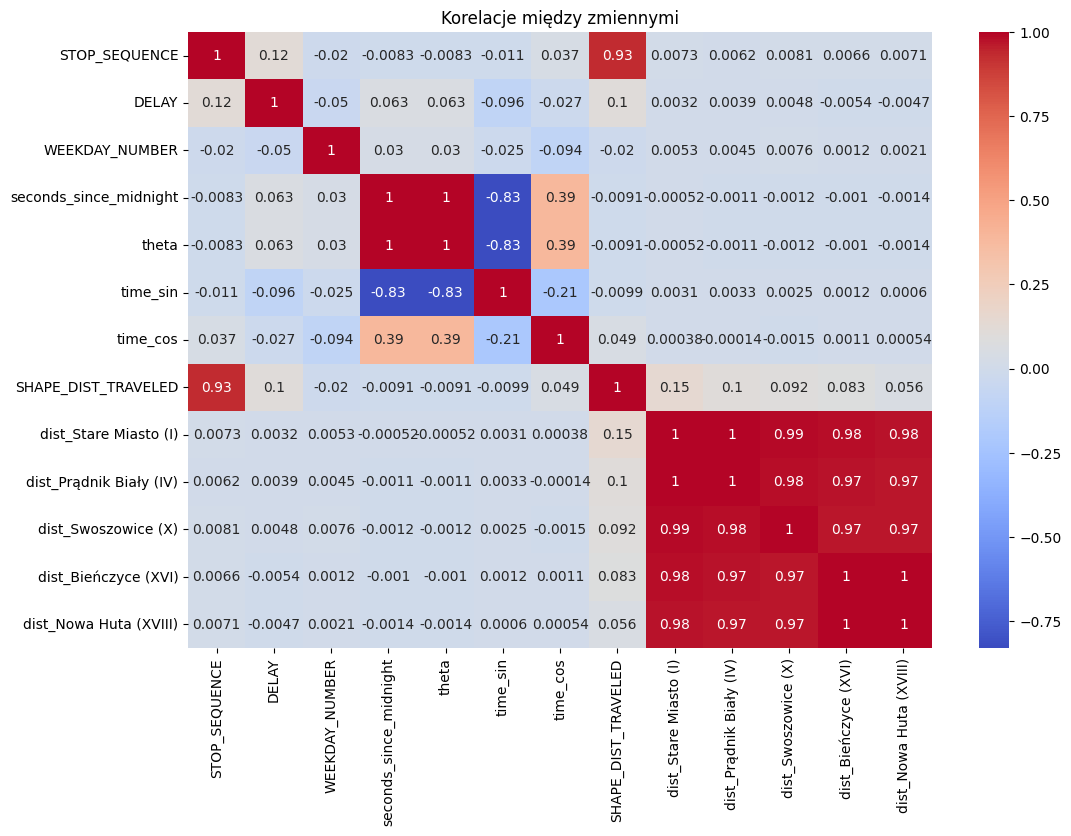

In [31]:
plt.figure(figsize=(12, 8))
sns.heatmap(num_features.corr(), annot=True, cmap='coolwarm')
plt.title('Korelacje między zmiennymi')
plt.show()

In [32]:
correlation_matrix = num_features.corr()
print("Korelacje między zmienną 'DELAY' a innymi zmiennymi numerycznymi:")
print(correlation_matrix['DELAY'].sort_values(ascending=False))

Korelacje między zmienną 'DELAY' a innymi zmiennymi numerycznymi:
DELAY                      1.000000
STOP_SEQUENCE              0.115335
SHAPE_DIST_TRAVELED        0.102349
seconds_since_midnight     0.062930
theta                      0.062930
dist_Swoszowice (X)        0.004805
dist_Prądnik Biały (IV)    0.003949
dist_Stare Miasto (I)      0.003152
dist_Nowa Huta (XVIII)    -0.004675
dist_Bieńczyce (XVI)      -0.005369
time_cos                  -0.026668
WEEKDAY_NUMBER            -0.049655
time_sin                  -0.096457
Name: DELAY, dtype: float64


### Analiza macierzy korelacji

* STOP_SEQUENCE: Słaba, ale najwyższa korelacja ze zmiennych obiektywnych. Potwierdza, że opóźnienia nieznacznie kumulują się w miarę pokonywania kolejnych przystanków (logiczne i intuicyjne).
* SHAPE_DIST_TRAVELED: Im dłuższy dystans trasy został już przebyty, tym większe opóźnienie (również efekt kumulacji).
* WEEKDAY_NUMBER: Bardzo słaba, ujemna korelacja. Sugeruje, że numerycznie wyższe dni tygodnia (np. piątek/sobota) mają nieco mniejsze opóźnienia, choć ta wartość jest zbyt niska, by była istotna. Jest to sprzeczne z analizą średnich (gdzie Czwartek i Piątek miały najwyższe średnie), co wskazuje, że **zależność jest nieliniowa i korelacja Pearsona jej nie wychwytuje.**
* Pomimo że wykresy punktowe wyraźnie pokazały, że bliskość centrum zwiększa ryzyko dużych opóźnień, związek ten nie jest liniowy. Korelacja Pearsona jest tutaj myląca i powinna zostać zignorowana na rzecz wyników innycg testów oraz analizy wykresów.

Pozostałe wartości mają słabe korelacje ze zmienną celu.

In [34]:
from scipy.stats import kruskal

features = df.columns.tolist()

for feature in features:
    groups = [group["DELAY"].dropna() for name, group in df.groupby(feature)]
    H, p = kruskal(*groups)

    print(f"\nAnaliza wariancji dla cechy: {feature}")
    print(f"Kruskal-Wallis H={H:.2f}, p-value={p:.4f}")
    if p < 0.05:
        print(f"Istnieje istotna różnica w opóźnieniach między grupami cechy {feature}.")


Analiza wariancji dla cechy: TRIP_ID
Kruskal-Wallis H=88138.01, p-value=0.0000
Istnieje istotna różnica w opóźnieniach między grupami cechy TRIP_ID.

Analiza wariancji dla cechy: STOP_ID
Kruskal-Wallis H=25635.66, p-value=0.0000
Istnieje istotna różnica w opóźnieniach między grupami cechy STOP_ID.

Analiza wariancji dla cechy: STOP_NAME
Kruskal-Wallis H=8489.96, p-value=0.0000
Istnieje istotna różnica w opóźnieniach między grupami cechy STOP_NAME.

Analiza wariancji dla cechy: TRIP_HEADSIGN
Kruskal-Wallis H=8709.69, p-value=0.0000
Istnieje istotna różnica w opóźnieniach między grupami cechy TRIP_HEADSIGN.

Analiza wariancji dla cechy: STOP_SEQUENCE
Kruskal-Wallis H=19424.15, p-value=0.0000
Istnieje istotna różnica w opóźnieniach między grupami cechy STOP_SEQUENCE.

Analiza wariancji dla cechy: ACTUAL_ARRIVAL
Kruskal-Wallis H=124021.38, p-value=0.0000
Istnieje istotna różnica w opóźnieniach między grupami cechy ACTUAL_ARRIVAL.

Analiza wariancji dla cechy: ROUTE_SHORT_NAME
Kruskal-Wall

Dla każdej analizowanej cechy, wartość $p$ wynosi $0.0000$ (znacznie mniej niż standardowy poziom istotności $\alpha = 0.05$). Oznacza to, że dla każdej zmiennej w zbiorze danych hipoteza zerowa (brak różnic w opóźnieniach między grupami danej cechy) została odrzucona.


Istnieje statystycznie istotna różnica w rozkładzie opóźnień (DELAY) w zależności od każdej badanej cechy.

Niestety na podstawie testu Kruskala-Wallisa, nie jesteśmy w stanie stwierdzić siły wpływu poszczególnych cech na opóźnienie, ani o kierunku zależności (liniowa/nieliniowa)

* Test potwierdza, że zmienne kategoryczne i identyfikatory (np. TRIP_ID, STOP_ID, ROUTE_SHORT_NAME, WEEKDAY) są ważnymi predyktorami. 
Wcześniejsze słabe wyniki korelacji Pearsona dla tych cech były mylące, ponieważ zakładały one liniowość.
* Test dowodzi, że różne sposoby kodowania czasu (ACTUAL_ARRIVAL, PLANNED_ARRIVAL, seconds_since_midnight, time_sin, time_cos) również prowadzą do statystycznie różnych rozkładów opóźnień.